<a href="https://colab.research.google.com/github/SolinSM/TDCGAN/blob/main/TDCGAN_Model_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TDCGAN Model**
Need To add Folder Called 'Datasets' -> and inside it add your CSV files

Here nead to run each step in this list before Run Code

*   init libraries
*   init Global Definition
*   Color List + Style Text
-----
*   Read Multi Files csv
*   Pre-process Data
-----
*   Build Models
    *   Build Generator Model
    *   Build Discriminator Model
    *   Build Combined Model
*   Print Models Summary
-----
*   Train
    *   Train Models  + Calculate Losses + Plot Losses
-----
*   evaluate_on_real
*   generate_synthetic_data    (not added yet)
-----
*   Run Code

# **libraries**

In [ ]:
#for read csv file
import os
import pandas as pd
import numpy as np
import random


# pre-process
##for stop word
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

## not used now
#import unicodedata     # Remove accents
#import string

import sklearn

## for tokenization
from nltk.tokenize import word_tokenize
from nltk.tokenize import WordPunctTokenizer      ## WordPunctTokenizer --> splits words based on punctuation boundaries.

## for divide data to (train / test/ validate)
from sklearn.model_selection import train_test_split


# for one-hor encode (sentence to 2D)
from sklearn.preprocessing import OneHotEncoder

# for TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

# for TDCGAN
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Input,
    Concatenate,
    Embedding,
    Dense,
    LeakyReLU,
    BatchNormalization,
    Dropout,
    Reshape,
)

import keras
from keras.optimizers import Adam

# taqadum in arabic , progress/process in english
from tqdm.notebook import tqdm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:

print(tf. __version__)      # tensorflow version

!python --version           # python version

print(sklearn.__version__)         # scikit-learn version

print(keras.__version__)           # keras version

2.15.0
Python 3.10.12
1.2.2
2.15.0


# **definition**

In [ ]:
NUM_DISCRIMINATORS = 3
GENERATOR_DROPOUT_RATE = 0.2  #0.1
DISCRIMINATOR_DROPOUT_RATE = 0.3      #Adjust the dropout rate to prevent overfitting during training.
LEAKY_RELU_ALPA = 0.2

NUM_EPOCHS = 500   #1000
BATCH_SIZE = 128
OPTIMIZER_LR = 0.0001                 # learning rate
OPTIMIZER_BETAS = (0.5, 0.999)

# Save losses for plotting
d0_real_losses = []   # left discriminator losses   (disc 0)
d0_fake_losses = []   # left discriminator losses   (disc 0)
d0_losses      = []   # discriminator losses        (disc 0)

d1_real_losses = []   # Middle discriminator losses (disc 1)
d1_fake_losses = []   # Middle discriminator losses (disc 1)
d1_losses      = []   # discriminator losses        (disc 1)

d2_real_losses = []   # right discriminator losses  (disc 2)
d2_fake_losses = []   # right discriminator losses  (disc 2)
d2_losses      = []   # discriminator losses        (disc 2)

g_losses       = []   # generator losses
d_losses       = []   # discriminator losses



# Suppress warnings from numpy
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)


# **Color list + TextStyle**

In [ ]:
colors_list = [
    'Red', 'Green', 'Blue', 'Purple', 'Orange', 'Pink', 'Brown', 'Yellow',
    'Cyan', 'Magenta', 'Lime', 'Teal', 'Lavender', 'Maroon', 'Navy', 'Olive', 'Silver', 'Gold',
    'Indigo', 'Turquoise', 'Beige', 'Crimson', 'Salmon','Tan','Lime', 'Fuchsia', 'Plum',
    'Tomato', 'Violet']

class TextStyle:
    # Font Styles
    BOLD = '\033[1m'
    DIM = '\033[2m'
    UNDERLINE = '\033[4m'
    BLINK = '\033[5m'
    REVERSE = '\033[7m'
    RESET_ALL = '\033[0m'

    # Font Colors
    BLACK = '\033[30m'
    RED = '\033[31m'
    GREEN = '\033[32m'
    YELLOW = '\033[33m'
    BLUE = '\033[34m'
    MAGENTA = '\033[35m'
    CYAN = '\033[36m'
    WHITE = '\033[37m'

    # Background Colors
    BG_BLACK = '\033[40m'
    BG_RED = '\033[41m'
    BG_GREEN = '\033[42m'
    BG_YELLOW = '\033[43m'
    BG_BLUE = '\033[44m'
    BG_MAGENTA = '\033[45m'
    BG_CYAN = '\033[46m'
    BG_WHITE = '\033[47m'


# **Read Multi Files csv**

In [ ]:
""" ----------------- Read CSV File Function ----------------- """
def read_csv_files(dataset_directory, percent):
  print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Handling Read CSV Files ------------{TextStyle.RESET_ALL}")

  files = [f for f in os.listdir(dataset_directory) if f.endswith('.csv')]

  if files == []:
    print('Not found any csv files')
  else:
    print('Your files are: ', files)

    np_array_values = []
    data_df = pd.DataFrame()
    firstFile = True

    for file in files:
      file_path = os.path.join(dataset_directory, file)   # csv_file_path
      print('File Path: ', file_path)

      try:
        df = ''
        df = pd.read_csv(file_path, encoding = "ISO-8859-1")  #.head()   #,low_memory=False   ISO-8859-1
        total_rows = len(df)
        print('Total rows in df/file: ', total_rows)

        num_rows = int(total_rows * (percent / 100))
        print('Total rows in df/file 100%: ', num_rows)


        """ Start From Teacher Code """
        # Generate a list of random indices
        random_indices = random.sample(range(total_rows), num_rows)
        #print('random_indices: ' , random_indices)

        # Select the random rows from the DataFrame
        temp_df = df.iloc[random_indices]
        if(firstFile):
          # Concatenate all DataFrames into one
          data_df = temp_df.copy()
          firstFile = False
        else:
          # Concatenate all DataFrames into one
          data_df = pd.concat([data_df,temp_df], ignore_index=True)

        print(data_df)
        return data_df
        """ End From Teacher Code """

        ## Add DataFrame to new CSV file
        #new_csv_file_path = os.path.join(dataset_directory, 'new_sqli.csv')  # "/content/dataset/new_sqli.csv"
        #df.to_csv(new_csv_file_path, index=False)

      except Exception as e:
        print('Can not Read File called : ', file)
        print('File path: ', file_path)
        print("Errpr Exception e : ", e)


#""" ----------------- Apply Code ----------------- """
#dataset_directory = "/content/datasets"   #files_path
#percent = 100
#data = read_csv_files(dataset_directory,percent)


# **pre-process data**

* Input text String
* Remove white spaces from start & end in text, using strip()
* Convert all letters of the string to lower case
* Remove accents (comment)
* Check for NaN & infinit Values (switch to 0)
* Tokenization
* Remove stop words, and except some important words used in queries
* Split data to Train/Test Data (70% / 30%)  --> (train_test_split)
* TfidfVectorizer instead of OneHotEncoder
* one_hot_encoder
* target_encode
* MinMaxScaler
* PCA

ref code: [https://www.geeksforgeeks.org/python-ai/?ref=shm](https://www.geeksforgeeks.org/python-ai/?ref=shm)


***Functions to used here (Extraction Features)***
*  filter_stop_words
*  tokenization_text  -->  contain filter_stop_words func.
*  Tfidf_Vectorizer
*  one_hot_encoder
*  target_encode

## **filter_stop_words**

In [ ]:
## ----- filter_stop_words ------ ##

"""
Filters stop words from a list of tokens, keeping words in the exception list.
Args:
    word_tokens: A list of tokens (words).
    except_stop_word: A set of stop words to be excluded from removal (optional).
Returns:
    A list of tokens with stop words removed, except for those in the exception list.
"""
def filter_stop_words(word_tokens):
    stop_words = set(stopwords.words('english'))  # Load default stop words
    except_stop_word = set(['and', 'or', 'where', 'from', 'over'])  # Exception list defined here

    filtered_sentence = []
    for w in word_tokens:
        if w in except_stop_word or w not in stop_words:
            filtered_sentence.append(w)

    return filtered_sentence


## **Tokenization**

In [ ]:
## ----- Tokenization ------ ##

"""
# Tokenization + stop word
Handle Main column in dataset 'sentence'
by encoding it using (Tokenization handlling OOV + stop_word  , TfidfVectorizer )
OOV :
    ensures any new words in the test data are mapped to a common OOV token.
    ensure robustness and accuracy when dealing with new, unseen words.
"""
def tokenization_text(sentences, x_name = ''):      #sentences):
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Tokenization + stop word (" , x_name , f") ------------{TextStyle.RESET_ALL}")

    #sentences = X['sentence']
    print('sentences: ' , len(sentences) )

    #define OOV token text to use it when new token appear and not in train tokens data
    #oov_token='<OOV>'

    tokenizer = WordPunctTokenizer()
    #tokenizer.oov_token = '<UNK>'   # '<OOV>'
    tokens = []

    for sentence in sentences:
        #word_tokens = word_tokenize(sentence)
        word_tokens = tokenizer.tokenize(sentence)

        # Replace OOV words with the specified token
        #word_tokens_with_oov = [token if token in tokenizer.vocab else oov_token for token in word_tokens]

        # stop_words  (filter tokeniz word by remove any stop word with except some word as from, where ... etc)
        filtered_tokens = filter_stop_words(word_tokens)


        ########tokens.extend(filtered_tokens)    ## for test 8:18 20-5-2024    #######
        tokens.append(filtered_tokens)

        # Join tokens back to string for TF-IDF
        #tokens.append(' '.join(filtered_tokens))


    #print('len tokens before unique: ', len(tokens))
    #print('1 tokens: ', tokens )

    # Get unique tokens ( Remove duplicates using set() and convert back to list )
    ######tokens = list(set(tokens))    #######
    #print('len tokens after unique: ', len(tokens))
    #print('2 tokens: ', tokens )

    print("tokens len:", len(tokens) )
    """
    i = 0
    for token in tokens:
      if i < 5:
        print("tokens:", tokens[i])
        i = i + 1
      else:
        break
    """
    return tokens



## **TF-IDF Vectorizer**

In [ ]:
## ----- TF-IDF Vectorizer ------ ##

"""
  Fit TF-IDF Vectorizer on the training data
  # Tf-idf Vectorizer (Term Frequency-Inverse Document Frequency Vectorizer)
  # Used to convert text data to numerical features
  # and get each one weight
  # care about frequency of a word within a sentence (term frequency)
  # and its rarity across the entire dataset (inverse document frequency)
  # It used for feature extraction in natural language processing (NLP).
"""
def Tfidf_Vectorizer(tokenized_sentence_joined, original_sentences, x_name):
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ TfidfVectorizer (" , x_name , f") ------------{TextStyle.RESET_ALL}")

    tfidf_vectorizer = TfidfVectorizer()   #max_features=5000)

    # Fit TF-IDF Vectorizer on the training data   #X_train_tfidf
    #/if(x_name == 'x_train'):
    X_tfidf = tfidf_vectorizer.fit_transform(tokenized_sentence_joined)     # X_train
    #/else:
    #/  X_tfidf = tfidf_vectorizer.transform(tokenized_sentence_joined)     # X_test

    #print('x_name : ' , x_name)
    #print('X_tfidf : ' , X_tfidf)

    # Extract feature names
    X_tfidf_selected_features = tfidf_vectorizer.get_feature_names_out()

    # Checking the shape of the output matrices
    print('Shape of X_tfidf : ', X_tfidf.shape)

    # Convert to DataFrame for better readability  #  df_X_train_tfidf
    df_X_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=X_tfidf_selected_features)   # index = original_sentences,index = original_sentences,
    print("Training data TF-IDF features: \n" , df_X_tfidf.head())

    return X_tfidf, df_X_tfidf



## **one_hot_encoder**

In [ ]:
## ----- one_hot_encoder_func ------ ##

def one_hot_encoder_func(X, one_hot_cols):
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Perform one-hot encoding ------------{TextStyle.RESET_ALL}")
    one_hot_encoded_df = X.copy()

    # Perform one-hot encoding
    one_hot_encoded_1 = pd.get_dummies(one_hot_encoded_df, columns=one_hot_cols, prefix=one_hot_cols)
    #print('one_hot_encoded : ', one_hot_encoded_1)

    # Get only columns that is original columns and needed as them + not neet to convert them from boolean to int
    origin_needed_cols = one_hot_encoded_1[[col for col in one_hot_encoded_1.columns if
                                            not any(col.startswith(col_name) for col_name in one_hot_cols)]]

    # Get only columns that created new by one-hoe-encoder (get_dummies)
    one_hot_cols_df = one_hot_encoded_1[[col for col in one_hot_encoded_1.columns if
                                          any(col.startswith(col_name) for col_name in one_hot_cols)]]

    # Convert one_hot_cols_df values from boolean to integers (1 and 0)
    one_hot_cols_df = one_hot_cols_df.astype(int)

    # Concatenate the one_hot_cols_df with the origin_needed_cols
    X = pd.concat([origin_needed_cols, one_hot_cols_df], axis=1)
    print('end one hot encoder : \n', X.head())

    """
      Ex of previous row:
          i  color  size              i     color_blue   color_red   size_M   size_S
          ---------------           ---------------------------------------------------
          0   red    S                0         0            1          0       1
          1   blue   M          ==>   1         1            0          1       0
          2   blue   S                2         1            0          0       1
    """

    return X


## **target_encode**

In [ ]:
## ----- target_encode ------ ##

"""
  # target encoding/mean encoding
  # useful for encoding categorical features into numerical features based on their relationship with the target variable.
  # target_column : deciding it will depend on the objective of your analysis or model training.
  # It is typically the variable you're trying to predict in a supervised learning task.

  NOTE::
    Target-encode might not be ideal for SQL sentences
      1. SQL sentences are unstructured text data with potentially high cardinality and no inherent ordering.
      2. Target encoding works better for categorical variables with a clear relationship to the target,
          rather than free-form text.
"""
def target_encode(X, y, target_encode_cols, target_column):
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Perform target encoding ------------{TextStyle.RESET_ALL}")

    target_encoded_df = X.copy()
    print('target_encoded_df: ', target_encoded_df.head())

    # this colum choisen because it is needed to predict sentence is normal or sqli
    #target_column = class_Col # y   #encoding_col
    for col in target_encode_cols:

        # Check if the column exists
        if col not in X.columns:
            raise KeyError(f"Column '{col}' not found in DataFrame")

        # Concate y  --> class_Col to X now then next remove it
        #class_Col_df = y.copy()
        X = pd.concat([X, y], axis=1)

        # Calculate the mean target value for each category  (the mean float no for each category in column)
        mean_encoding = X.groupby(col)[target_column].mean()
        print('mean_encoding: ', mean_encoding.head())

        # Map the mean values back to the DataFrame
        target_encoded_df[col + '_encoded'] = X[col].map(mean_encoding)
        #print('target_encoded_df: ', target_encoded_df.head())

        # Drop class_Col added to do this part
        X = X.drop(target_column, axis=1)

        # Drop the original categorical column
        target_encoded_df = target_encoded_df.drop(col, axis=1)
        print('target_encoded_df: ', target_encoded_df.head())

        X = target_encoded_df

    return X



## **MinMaxScaler**

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def apply_scaler(X_data, x_name):
  # Scaling Features :: Standardize the features (PCA works better on standardized data)

  #print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Scaling Features using 'StandardScaler' ------------{TextStyle.RESET_ALL}")
  #scaler = StandardScaler()

  print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Scaling Features using 'MinMaxScaler' ------------{TextStyle.RESET_ALL}")
  scaler = MinMaxScaler()

  #/if x_name == 'x_train':
  X_scaled = scaler.fit_transform(X_data.drop(['sentence'], axis=1))
  #/else:
  #/  X_scaled = scaler.transform(X_data.drop(['sentence'], axis=1))
  #/print('X_scaled : ' , X_scaled.head())

  # Convert the scaled numerical features back to DataFrames
  X_scaled_df = pd.DataFrame(X_scaled, columns=X_data.drop(['sentence'], axis=1).columns)
  #/print('X_scaled_df : ' , X_scaled_df.head())

  return X_scaled, X_scaled_df


## **performs feature selection using PCA (not used yet)**

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler


"""
performs feature selection using Principal Component Analysis (PCA)
Args:
  data: X , which is array value of (num_rows, features)
  n_components : cols num. without dropd y column (column features)
  dataset_name : just name of dataset file
Returns:
  selected features df  (X_train_final_df, X_test_final_df)
"""
def simple_perform_pca_new(n_components, x_name, X_scaled , y ):
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ PCA ------------{TextStyle.RESET_ALL}")

    # Fit & Transform PCA on the training data
    pca = PCA(n_components=n_components, random_state=453)
    print('pca: ' , pca)


    #/if(x_name == 'x_train'):
    X_pca = pca.fit_transform(X_scaled)
    #/else:
    #/    X_pca = pca.transform(X_scaled)   # Only Transform the test data using the same PCA , to avoid data leakage

    print('X_pca: ' , X_pca)
    print(456)

    # Convert PCA results back to DataFrames and concatenate with the original non-sentence columns
    # Generate new feature names for PCA components
    pca_feature_names = [f'pca_{i+1}' for i in range(X_pca.shape[1])]

    # Create a DataFrame with the PCA-transformed data
    X_pca_df = pd.DataFrame(data=X_pca, columns=pca_feature_names)

    ##X_pca_df = pd.DataFrame(data=X_pca, columns=X_train_feature_names)
    print('X_pca_df: ', X_pca_df)
    print('X_pca_df shape: ', X_pca_df.shape)

    print(789)
    # Combine the PCA-transformed features with the target variable
    X_final_df = pd.concat([X_pca_df, y.reset_index(drop=True)], axis=1)
    print(12333)

    return X_final_df


    """
    ## X_train_combined <- X_train_prepared
    #change components number in case new columns add after preprossing
    ##n_components = df_X_train_tfidf.shape[1]      # cols num.   #without dropd y column     ## 23-5-2024 approch 1
    #n_components = X_train_prepared.shape[1]      # or any desired number of components
    #print('n_components : ', n_components)

    # selected_features_df
    n_components = 0.97
    X_train_selected_features_df = perform_pca_new_1(n_components, 'x_train', X_scaled_df) #X_train_prepared)
    """

    """
    # selected_features_df
    #X_train_selected_features_df, X_test_selected_features_df = perform_pca(df_X_train_tfidf, df_X_test_tfidf, n_components=n_components, dataset_name= 'file csv' )
    df_X_test_tfidf = []
    X_train_final_df = perform_pca(df_X_train_tfidf, df_X_test_tfidf, n_components=n_components, dataset_name= 'file csv' )

    columns_witout_target = X_train_selected_features_df.columns

    #change components number in case new columns add after preprossing
    n_components = X_train_selected_features_df.shape[1] - 1
    """

def perform_pca_new(n_components, x_name, X_scaled ):
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ PCA ------------{TextStyle.RESET_ALL}")

    # Fit & Transform PCA on the training data
    pca = PCA(n_components=n_components, random_state=453)
    print('pca: ' , pca)


    if(x_name == 'x_train'):
        X_pca = pca.fit_transform(X_scaled)
    else:
        X_pca = pca.transform(X_scaled)   # Only Transform the test data using the same PCA , to avoid data leakage

    print('X_pca: ' , X_pca)


    # variance ratio : show how much information (variance) can be attributed to each of the principal components.
    # Calculate explained variance ratio and cumulative variance
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance      = np.cumsum(explained_variance_ratio)    # Calculates the cumulative explained variance ratio for each component.
    #print('explained_variance_ratio: ', explained_variance_ratio)
    #print('cumulative_variance: ', cumulative_variance)


    # Plot component variance and cumulative variance
    plt.figure(figsize=(12, 4))
    colors_list = ['Red','Orange', 'Blue', 'Purple','Green','Pink','Gray','Tan','Lime','Cyan']

    # Plot component variance with percentages
    plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio * 100, label='Component Variance')
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance * 100, marker='o', color='r', label='Cumulative Variance')

    plt.title('Variance Explained by Principal Components\n Dataset ')
    plt.xlabel('Principal Component')
    plt.ylabel('Percentage of Variance Explained (%)')
    plt.legend()
    plt.grid(True)
    plt.show()




    # Determine the number of components to keep 97%+ of the variance
    number_of_cumulative_variance = 0     # 1   # init the number of components to keep
    vsum = 0                                    # to sum variance for each component (sumcum)
    for n in explained_variance_ratio:
        if vsum < 0.96:
            number_of_cumulative_variance += 1
        vsum += n

    print('number_of_cumulative_variance: ', number_of_cumulative_variance)

    # Ensure PCA output is float32
    X_pca = X_pca.astype(np.float32)

    # Get the components matrix (loadings)
    components = pca.components_

    # Get the selected feature names (corresponding to the original columns with highest loadings)
    X_train_feature_names = X_scaled.columns.tolist()
    Xt_selected_features_order = pd.DataFrame(components, columns=X_train_feature_names)
    Xt_selected_features_order = Xt_selected_features_order.abs().idxmax(axis=1)
    Xt_selected_features_order = Xt_selected_features_order.drop_duplicates()

    Xt_selected_features = Xt_selected_features_order[:number_of_cumulative_variance]
    print("Keep 97%+ of the variance and thus keep " + str(number_of_cumulative_variance) + " Principal components from " + str(n_components) + ".\n")

    print(f"{TextStyle.BOLD}X train Selected_features:{TextStyle.RESET_ALL} \n")
    print(Xt_selected_features[:number_of_cumulative_variance +1])


    # Create a DataFrame for PCA results
    print('shap X_pca: ', X_pca.shape)
    print('shap X_train_feature_names: ', X_train_feature_names)




    # Transform the data using selected components
    if(x_name == 'x_train'):
        #X_pca = pca.fit_transform(X_scaled.toarray())[:, :number_of_cumulative_variance]
        X_pca = pca.fit_transform(X_scaled)[:, :number_of_cumulative_variance]
    else:
        # Only Transform the test data using the same PCA , to avoid data leakage
        #X_pca = pca.transform(X_scaled.toarray())[:, :number_of_cumulative_variance]
        X_pca = pca.transform(X_scaled)[:, :number_of_cumulative_variance]

    print('X_pca 2: ' , X_pca)
    print('X_pca 2 shape: ' , X_pca.shape)
    print('X_train_feature_names len: ' , len(X_train_feature_names))



    # Number of top features to identify
    num_top_features = X_pca.shape[1]  #10

    # Identify top contributing features for each principal component
    top_features_per_component = []
    for component in components:
        top_feature_indices = np.argsort(np.abs(component))[-num_top_features:]
        top_feature_names = [X_train_feature_names[i] for i in top_feature_indices]
        top_features_per_component.append(top_feature_names)


    # Create a DataFrame to display the top features for each component
    # identifying and inspecting the most important original features for each principal component.
    top_features_df = pd.DataFrame(top_features_per_component, columns=[f'Top_Feature_{i+1}' for i in range(num_top_features)])
    top_features_df.index = [f'Component_{i+1}' for i in range(components.shape[0])]



    # Convert PCA results back to DataFrames and concatenate with the original non-sentence columns
    # Generate new feature names for PCA components
    pca_feature_names = [f'pca_{i+1}' for i in range(X_pca.shape[1])]

    # Create a DataFrame with the PCA-transformed data
    X_pca_df = pd.DataFrame(data=X_pca, columns=pca_feature_names)

    ##X_pca_df = pd.DataFrame(data=X_pca, columns=X_train_feature_names)
    print('X_pca_df: ', X_pca_df)
    print('X_pca_df shape: ', X_pca_df.shape)

    # Combine the PCA-transformed features with the target variable
    #/X_final_df = pd.concat([X_pca_df, y.reset_index(drop=True)], axis=1)



    # Define selected features (for example, selecting first 10 principal components)
    Xt_selected_features = pca_feature_names[:X_pca_df.shape[1]]  # Modify this based on your criteria for feature selection

    # Create final DataFrame with selected features
    X_final_df = X_pca_df[Xt_selected_features]
    X_final_df.reset_index(inplace=True, drop=True)


    return X_final_df



def perform_pca_new_1(n_components, x_name, X_scaled ):     #approch to use
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ PCA ------------{TextStyle.RESET_ALL}")
    #n_components = X_scaled.shape[1]
    #n_components = min(X_scaled.shape[0], X_scaled.shape[1])  # ensure we have a valid number of components

    no_x = X_scaled.shape[0]
    no_y = X_scaled.shape[1]

    # if (no_y > no_x) ? no_x : X_scaled.shape[1]
    n_components = no_x if no_y > no_x else X_scaled.shape[1]
    print('n_components: ' , n_components)


    print('X_scaled: ' , X_scaled)

    # Fit & Transform PCA on the training data
    pca = PCA(n_components=n_components)      # Number of components initially set to all features
    print('pca: ' , pca)


    if(x_name == 'x_train'):
        X_pca = pca.fit_transform(X_scaled)
    else:
        # Only Transform the test data using the same PCA , to avoid data leakage
        X_pca = pca.transform(X_scaled)

    print('X_pca: ' , X_pca)


    # variance ratio : show how much information (variance) can be attributed to each of the principal components.
    # Calculate explained variance ratio and cumulative variance
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance      = np.cumsum(explained_variance_ratio)    # Calculates the cumulative explained variance ratio for each component.
    print('explained_variance_ratio: ', explained_variance_ratio)
    print('cumulative_variance: ', cumulative_variance)



    # Plot component variance and cumulative variance
    plt.figure(figsize=(12, 4))
    colors_list = ['Red','Orange', 'Blue', 'Purple','Green','Pink','Gray','Tan','Lime','Cyan']

    # Plot component variance with percentages
    plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio * 100, label='Component Variance')
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance * 100, marker='o', color='r', label='Cumulative Variance')

    plt.title('Variance Explained by Principal Components\n Dataset ')
    plt.xlabel('Principal Component')
    plt.ylabel('Percentage of Variance Explained (%)')
    plt.legend()
    plt.grid(True)
    plt.show()



    # Get the selected feature names (corresponding to the original columns with highest loadings)
    # pca.components_ :
    X_train_feature_names = X_scaled.columns.tolist()
    Xt_selected_features_order = pd.DataFrame(pca.components_, columns=X_train_feature_names)
    Xt_selected_features_order = Xt_selected_features_order.abs().idxmax(axis=1)
    Xt_selected_features_order = Xt_selected_features_order.drop_duplicates()

    Xt_selected_features = Xt_selected_features_order[:cumulative_variance]
    print("Keep 97%+ of the variance and thus keep " + str(cumulative_variance) + " Principal components from " + str(n_components) + ".\n")

    print(f"{TextStyle.BOLD}X train Selected_features:{TextStyle.RESET_ALL} \n")
    print(Xt_selected_features[:cumulative_variance +1])

    # Transform the data using selected components
    if(x_name == 'x_train'):
        X_pca = pca.fit_transform(X_scaled.toarray())[:, :cumulative_variance]
    else:
        # Only Transform the test data using the same PCA , to avoid data leakage
        X_pca = pca.transform(X_scaled.toarray())[:, :cumulative_variance]

    print('X_pca: ' , X_pca)




    """
    # Determine the number of components to keep 97%+ of the variance
    number_of_cumulative_variance = 0     # 1   # init the number of components to keep
    vsum = 0                                    # to sum variance for each component (sumcum)
    for n in explained_variance_ratio:
        if vsum < 0.98:
            number_of_cumulative_variance += 1
        vsum += n

    #n_components = X_scaled.shape[1]

    print('X_scaled.columns : ' , X_scaled.columns)

    # Get the selected feature names (corresponding to the original columns with highest loadings)
    X_train_feature_names = X_scaled.columns.tolist()
    Xt_selected_features_order = pd.DataFrame(pca.components_, columns=X_train_feature_names)
    Xt_selected_features_order = Xt_selected_features_order.abs().idxmax(axis=1)
    Xt_selected_features_order = Xt_selected_features_order.drop_duplicates()

    Xt_selected_features = Xt_selected_features_order[:number_of_cumulative_variance]
    print("Keep 97%+ of the variance and thus keep " + str(number_of_cumulative_variance) + " Principal components from " + str(n_components) + ".\n")

    print(f"{TextStyle.BOLD}X train Selected_features:{TextStyle.RESET_ALL} \n")
    print(Xt_selected_features[:number_of_cumulative_variance +1])


    # Transform the data using selected components
    if(x_name == 'x_train'):
        X_pca = pca.fit_transform(X_scaled.toarray())[:, :number_of_cumulative_variance]
    else:
        # Only Transform the test data using the same PCA , to avoid data leakage
        X_pca = pca.transform(X_scaled.toarray())[:, :number_of_cumulative_variance]

    print('X_pca: ' , X_pca)

    """

    # Create a DataFrame for PCA results
    X_pca_df = pd.DataFrame(data=X_pca, columns=X_train_feature_names)
    X_final_df = X_pca_df[Xt_selected_features]
    X_final_df.reset_index(inplace=True, drop=True)

    return X_final_df



def perform_pca_old(df_X_train_tfidf, n_components, dataset_name):     #df_X_test_tfidf,
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}Principal Component Analysis (PCA){TextStyle.RESET_ALL}")

    # Extract feature names
    X_train_feature_names = df_X_train_tfidf.columns.tolist()


    # Fit & Transform PCA on the training data
    pca = PCA(n_components=n_components)      # Number of components initially set to all features
    X_train_pca = pca.fit_transform(X_train_scaled)

    # Only Transform the test data using the same PCA , to avoid data leakage
    #X_test_pca = pca.transform(X_test_scaled)

    # Check the shapes of the transformed data
    print("Original training data shape:", df_X_train_tfidf.shape)
    print("Transformed training data shape:", X_train_pca.shape)
    #print("Original testing data shape:", df_X_test_tfidf.shape)
    #print("Transformed testing data shape:", X_test_pca.shape)


    # variance ratio : show how much information (variance) can be attributed to each of the principal components.
    # Calculate explained variance ratio and cumulative variance
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance      = np.cumsum(explained_variance_ratio)    # Calculates the cumulative explained variance ratio for each component.



    # Plot component variance and cumulative variance
    plt.figure(figsize=(12, 4))

    # Plot component variance with percentages
    plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio * 100, label='Component Variance')
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance * 100, marker='o', color='r', label='Cumulative Variance')

    plt.title('Variance Explained by Principal Components\n Dataset: ' + dataset_name)
    plt.xlabel('Principal Component')
    plt.ylabel('Percentage of Variance Explained (%)')
    plt.legend()
    plt.grid(True)
    plt.show()




    # Determine the number of components to keep 97%+ of the variance
    number_of_cumulative_variance = 0     # 1   # init the number of components to keep
    vsum = 0                                    # to sum variance for each component (sumcum)
    for n in explained_variance_ratio:
        if vsum < 0.98:
            number_of_cumulative_variance += 1
        vsum += n


    # Get the selected feature names (corresponding to the original columns with highest loadings)
    Xt_selected_features_order = pd.DataFrame(pca.components_, columns=X_train_feature_names)
    Xt_selected_features_order = Xt_selected_features_order.abs().idxmax(axis=1)
    Xt_selected_features_order = Xt_selected_features_order.drop_duplicates()

    Xt_selected_features = Xt_selected_features_order[:number_of_cumulative_variance]
    print("Keep 97%+ of the variance and thus keep " + str(number_of_cumulative_variance) + " Principal components from " + str(n_components) + ".\n")

    print(f"{TextStyle.BOLD}X train Selected_features:{TextStyle.RESET_ALL} \n")
    print(Xt_selected_features[:number_of_cumulative_variance +1])


    # Transform the data using selected components
    #X_train_pca = pca.fit_transform(X_train_tfidf.toarray())[:, :number_of_cumulative_variance]
    #X_test_pca = pca.transform(X_test_tfidf.toarray())[:, :number_of_cumulative_variance]


    """  Start net code """
    """# Determine the number of components based on explained variance ratio
    total_variance = np.sum(pca.explained_variance_)
    explained_variance_ratio = cumulative_variance / total_variance
    num_components = np.searchsorted(explained_variance_ratio, explained_variance_ratio) + 1

    # Select features based on explained variance ratio threshold
    selected_features = pca.components_[:, :num_components]
    print(f"{TextStyle.BOLD}Selected_features:{TextStyle.RESET_ALL} \n")

    # Transform data using selected components
    X_train_reduced = pca.transform(X_train_scaled)[:, :num_components]
    print('X_train_reduced : ', X_train_reduced)
    X_test_reduced = pca.transform(X_test_scaled)[:, :num_components]
    print('X_test_reduced : ', X_test_reduced)
    """
    """ End net code """

    # Create a DataFrame for PCA results
    X_train_pca_df = pd.DataFrame(data=X_train_pca, columns=X_train_feature_names)
    X_train_final_df = X_train_pca_df[Xt_selected_features]
    X_train_final_df.reset_index(inplace=True, drop=True)

    #X_test_pca_df = pd.DataFrame(data=X_test_pca, columns=X_train_feature_names)
    #X_test_final_df = X_test_pca_df[Xt_selected_features]
    #X_test_final_df.reset_index(inplace=True, drop=True)


    return X_train_final_df  #, X_test_final_df



## **Run Pre-process function (oll struct pre- in v1)**

In [ ]:

def preprocess_data(df_data, class_Col, x_name, main_text_col = ''):
  print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Pre-Proccess Data ------------{TextStyle.RESET_ALL}")


  ## Remove rows with missing target.
  #//print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Handling Missing Target ------------{TextStyle.RESET_ALL}")
  #//print("Remove rows with missing target, separate target from predictors")


  # ----------- Check for NaN Values ------------- #
  print("Checking for NaN vallues ...")
  if df_data.isnull().values.any():
      print("NaN values found in the dataset. Handling missing values...")
      # Handling missing values by imputing with mean (you can choose other methods as well)
      df_data = df_data.fillna(df_data.mean())

  df_data.replace([np.inf, -np.inf,np.nan,np.NAN],0, inplace=True)

  # Check again to ensure there are no NaN or Infinite values after handling
  #print(df_data.isnull().sum().sum())  # Should print 0

  if df_data.isnull().sum().sum() == 0 : # and np.isinf(df_data.values).sum() == 0 :
      print('Done Handling missing values')





  # ----------- lowercase + strip 'sentence' ------------- #
  # Convert to lowercase & Remove spaces in start and end
  df_data['sentence'] = df_data['sentence'].str.lower().str.strip()

  # Remove accents (optional)
  # df_data['sentence'] = ''.join(x for x in unicodedata.normalize('NFKD', df_data['sentence']) if x in string.ascii_letters or x == " ")



  # ------------------------------------  separate target from predictors ------------------------------------ #
  print(f"{TextStyle.BOLD}{TextStyle.BLACK}separate target from predictors{TextStyle.RESET_ALL}")

  # no. classes/category in class_Col (attack_type)
  n_classes = df_data[class_Col].nunique()
  print("n_classes: ", n_classes)

  # main col to classify at end (class_Col --> attack_type)
  y = df_data[class_Col]
  #y_attack_type = np.unique(y).tolist()   # no need now
  print("y: ", y)

  # remove y column (class_Col) from data columns list (df_data)
  df_data.drop([class_Col], axis=1, inplace=True)           # comment prev. 10:00 - 19-5-2024
  print("df_data: ", df_data)

  X = df_data.copy()
  X_columns = X.columns       #['sentence', 'len_payload', ....]
  print("X_columns: ", X_columns)

  print(" X: ", X.shape)
  print(" y: ", y.shape)

  #x_sentence_data = X['sentence']
  #print('X_columns : ', X['sentence'])




  # ------------------------------------ Apply encoding for categorical columns if any ------------------------------------ #
  print(f"{TextStyle.BOLD}{TextStyle.BLACK}Handling Categorical Features{TextStyle.RESET_ALL}")
  # all categorical columns (any column with object dataType ant its value not number)
  categorical_cols = [cname for cname in X.columns if
                      X[cname].dtype == "object"]
  print("Categorical columns len: ", len(categorical_cols))
  print("Categorical columns: ", categorical_cols)

  # Columns that will be one-hot encoded
  # X[cname].nunique() < 4   : less that 4 categories in the column
  one_hot_cols = [cname for cname in X.columns if
                    X[cname].nunique() < 4 and
                    X[cname].dtype == "object"]
  print('one_hot_cols : ', one_hot_cols)
  print("No. Columns need to encoded using one-hot-encoding: ", len(one_hot_cols))

  # Skip this columns because it needs to use TfidFVectorizer With it
  skip_cols = [main_text_col]

  # Columns that will be target encoded  (will get columns with more than 4 categories in it :: like 'sentence' column)
  target_encode_cols = list(set(categorical_cols)-set(one_hot_cols) - set(skip_cols) )
  print('target_encode_cols : ', target_encode_cols)
  print("No. Columns need to encoded using target-encoding: ", len(target_encode_cols))


  # Encode categorical columns if there is any
  if(len(categorical_cols) > 0):

    # to perform one-hot encoding on specified columns of a DataFrame.
    if(len(one_hot_cols)> 0):
      X = one_hot_encoder_func(X, one_hot_cols)

    if(len(target_encode_cols) > 0):
      target_column = class_Col
      X = target_encode(X, y, target_encode_cols, target_column)

  else:
    print("No categorical columns, nothing todo")



  # ------------------------------------ train_test_split ------------------------------------ #
  # Divide the dataset into training (70%) and testing (30%)
  print(f"{TextStyle.BOLD}{TextStyle.BLACK}---------------- Divide the dataset into training (70%) and testing (30%) ----------------{TextStyle.RESET_ALL}")
  #### selected_features_df, y_encoder
  selected_features_df = X   #df_data['sentence']  #x_sentence_data
  y_encoder = y  #_attack_type
  #X_train, X_test, y_train, y_test = train_test_split(selected_features_df, y_encoder, test_size=0.3, random_state=42,stratify=y)
  X_train, X_test, y_train, y_test = train_test_split(X, y_encoder, test_size=0.3, random_state=42,stratify=y)
  print(f"X_train shape: {X_train.shape}")
  print(f"y_train shape: {y_train.shape}")
  print(f"X_test shape : {X_test.shape}")
  print(f"y_test shape : {y_test.shape}")

  X_train_copy  = X_train.copy()
  X_test_copy   = X_test.copy()
  y_train_copy  = y_train.copy()
  y_test_copy   = y_test.copy()

  print(f"X_train : {X_train_copy}")



  # ------------------------------------ Tokenization train data ------------------------------------ #
  # Tokenize sentences
  X_train_tokenized = tokenization_text(X_train_copy['sentence'], 'x_train')
  #X_test_tokenized = tokenization_text(X_test_copy['sentence'], 'x_test')

  # Join tokens back into strings for each sentence
  X_train_joined_sentences = [' '.join(tokens) for tokens in X_train_tokenized]     #X_train_copy['sentence_joined'] = ' '.join(X_train_tokenized)
  #X_test_joined_sentences = [' '.join(tokens) for tokens in X_train_tokenized]
  #/print('joined_sentences: ' , joined_sentences)



  # ------------------------------------ TfidfVectorizer train data ------------------------------------ #
  X_train_tfidf, df_X_train_tfidf = Tfidf_Vectorizer(X_train_joined_sentences, X_train_copy['sentence'], 'x_train')
  #/print('X_train_tfidf: ' , X_train_tfidf)
  #/print('df_X_train_tfidf: ' , df_X_train_tfidf)

  print(f"{TextStyle.BLUE}--- again ----{TextStyle.RESET_ALL}")
  print('X_train_copy shape : ', X_train_copy.shape)
  #/print('X_train_tfidf shape : \n', X_train_tfidf.shape)
  print('df_X_train_tfidf shape : ', df_X_train_tfidf.shape)
  print('123 : End TfidfVectorizer')


  # ------------------------------------ Standardize other numerical columns ------------------------------------ #
  # Standardize the Data (mean = 0 and variance = 1)

  ### X_train data ###
  # Ensure indices are unique
  X_train_copy = X_train_copy.reset_index(drop=True)
  df_X_train_tfidf = df_X_train_tfidf.reset_index(drop=True) #, inplace=True)

  # Concatenate TF-IDF features with the original data excluding the sentence column
  X_train_combined = pd.concat([X_train_copy, df_X_train_tfidf], axis=1)    #.drop(['sentence'], axis=1)
  #/print('X_train_combined shape : ' , X_train_combined.shape)
  #/print('X_train_combined : ' , X_train_combined)

  # Apply Scaler
  X_train_scaled, X_train_scaled_df = apply_scaler(X_train_combined, 'x_train')
  #/print('X_scaled_df shape: ', X_scaled_df.shape)
  #/print('X_scaled_df: ', X_scaled_df)

  print(f"{TextStyle.BLUE}--- again ----{TextStyle.RESET_ALL}")
  print('X_train_combined shape : ' , X_train_combined.shape)
  print('X_train_scaled_df shape: ', X_train_scaled_df.shape)




  # ------------------------------------ PCA for feature selection ------------------------------------ #
  """
  no_x = X_scaled.shape[0]
  no_y = X_scaled.shape[1]    #n_components
  n_components = no_x if no_y > no_x else X_scaled.shape[1]     # if (no_y > no_x) ? no_x : X_scaled.shape[1]
  print('n_components: ' , n_components)
  """
  n_components = 0.95
  X_train_final_df = simple_perform_pca_new(n_components, 'x_train', X_train_scaled_df , y_train_copy )
  X_final_df = X_train_final_df



  return n_classes, X_train_copy, X_test_copy, y_train_copy, y_test_copy, n_components, X_final_df







def preprocess_data_test(X_test, y_test):

  # ------------------------------------ Tokenization train data ------------------------------------ #
  # Tokenize sentences
  X_test_tokenized = tokenization_text(X_test['sentence'], 'x_test')

  # Join tokens back into strings for each sentence
  X_test_joined_sentences = [' '.join(tokens) for tokens in X_test_tokenized]



  # ------------------------------------ TfidfVectorizer train data ------------------------------------ #
  X_test_tfidf, df_X_test_tfidf = Tfidf_Vectorizer(X_test_joined_sentences, X_test['sentence'], 'x_test')

  # ------------------------------------ Standardize other numerical columns ------------------------------------ #
  # Standardize the Data (mean = 0 and variance = 1)
  X_test = X_test.reset_index(drop=True)
  df_X_test_tfidf = df_X_test_tfidf.reset_index(drop=True) #, inplace=True)

  # Concatenate TF-IDF features with the original data excluding the sentence column
  X_test_combined = pd.concat([X_test, df_X_test_tfidf], axis=1)

  # Apply Scaler
  X_test_scaled, X_test_scaled_df = apply_scaler(X_test_combined, 'x_test')



  # ------------------------------------ PCA for feature selection ------------------------------------ #
  n_components = 0.95
  X_test_final_df = simple_perform_pca_new(n_components, 'x_test', X_test_scaled_df , y_test )
  X_final_df = X_test_final_df
  print('-- End PCA test')


  return X_test, y_test, n_components, X_final_df


  """ ---------------- Apply --------------------
  # Read Data of CSV Files
  dataset_directory = "/content/datasets"   #files_path
  percent = 100
  data = read_csv_files(dataset_directory,percent)
  print('len data : ' , len(data))


  # Apply pre-processing
  main_text_col = 'sentence'
  class_Col = 'attack_type'
  n_classes, X_train_copy, X_test_copy, y_train_copy, y_test_copy, n_components, X_train_final_df = preprocess_data(data, class_Col, 'csv files', main_text_col)

  #n_classes, X_train, X_test, y_train, y_test, X_train_tfidf, \
  #X_test_tfidf, df_X_train_tfidf, df_X_test_tfidf = preprocess_data(data, class_Col, 'csv files', main_text_col)
  #n_classes, X_train_copy, X_test_copy, y_train_copy, y_test_copy,  \
  #X_train_tfidf, X_test_tfidf, df_X_train_tfidf, df_X_test_tfidf, \
  #X_train_selected_features_df, X_test_selected_features_df, n_components = preprocess_data(data, class_Col, 'csv files', main_text_col)

  """


***Train Part Pre-process***

In [ ]:

def train_part_preprocess():
  # ------------------------------------ train_test_split ------------------------------------ #
      # Divide the dataset into training (70%) and testing (30%)
      print(f"{TextStyle.BOLD}{TextStyle.BLACK}---------------- Divide the dataset into training (70%) and testing (30%) ----------------{TextStyle.RESET_ALL}")
      #### selected_features_df, y_encoder
      selected_features_df = X   #df_data['sentence']  #x_sentence_data
      y_encoder = y  #_attack_type
      #X_train, X_test, y_train, y_test = train_test_split(selected_features_df, y_encoder, test_size=0.3, random_state=42,stratify=y)
      X_train, X_test, y_train, y_test = train_test_split(X, y_encoder, test_size=0.3, random_state=42,stratify=y)
      print(f"X_train shape: {X_train.shape}")
      print(f"y_train shape: {y_train.shape}")
      print(f"X_test shape : {X_test.shape}")
      print(f"y_test shape : {y_test.shape}")

      X_train_copy  = X_train.copy()
      X_test_copy   = X_test.copy()
      y_train_copy  = y_train.copy()
      y_test_copy   = y_test.copy()

      print(f"X_train : {X_train_copy}")



      # ------------------------------------ Tokenization train data ------------------------------------ #
      # Tokenize sentences
      X_train_tokenized = tokenization_text(X_train_copy['sentence'], 'x_train')
      X_test_tokenized = tokenization_text(X_test_copy['sentence'], 'x_test')

      # Join tokens back into strings for each sentence
      X_train_joined_sentences = [' '.join(tokens) for tokens in X_train_tokenized]     #X_train_copy['sentence_joined'] = ' '.join(X_train_tokenized)
      X_test_joined_sentences = [' '.join(X_train_tokenized)]
      #/print('joined_sentences: ' , joined_sentences)



      # ------------------------------------ TfidfVectorizer train data ------------------------------------ #
      X_train_tfidf, df_X_train_tfidf = Tfidf_Vectorizer(X_train_joined_sentences, X_train_copy['sentence'], 'x_train')
      #/print('X_train_tfidf: ' , X_train_tfidf)
      #/print('df_X_train_tfidf: ' , df_X_train_tfidf)

      print(f"{TextStyle.BLUE}--- again ----{TextStyle.RESET_ALL}")
      print('X_train_copy shape : ', X_train_copy.shape)
      #/print('X_train_tfidf shape : \n', X_train_tfidf.shape)
      print('df_X_train_tfidf shape : ', df_X_train_tfidf.shape)
      print('123 : End TfidfVectorizer')


      # ------------------------------------ Standardize other numerical columns ------------------------------------ #
      # Standardize the Data (mean = 0 and variance = 1)

      ### X_train data ###
      # Ensure indices are unique
      X_train_copy = X_train_copy.reset_index(drop=True)
      df_X_train_tfidf = df_X_train_tfidf.reset_index(drop=True) #, inplace=True)

      # Concatenate TF-IDF features with the original data excluding the sentence column
      X_train_combined = pd.concat([X_train_copy, df_X_train_tfidf], axis=1)    #.drop(['sentence'], axis=1)
      #/print('X_train_combined shape : ' , X_train_combined.shape)
      #/print('X_train_combined : ' , X_train_combined)

      # Apply Scaler
      X_train_scaled, X_train_scaled_df = apply_scaler(X_train_combined, 'x_train')
      #/print('X_scaled_df shape: ', X_scaled_df.shape)
      #/print('X_scaled_df: ', X_scaled_df)

      print(f"{TextStyle.BLUE}--- again ----{TextStyle.RESET_ALL}")
      print('X_train_combined shape : ' , X_train_combined.shape)
      print('X_train_scaled_df shape: ', X_train_scaled_df.shape)




      # ------------------------------------ PCA for feature selection ------------------------------------ #
      """
      no_x = X_scaled.shape[0]
      no_y = X_scaled.shape[1]    #n_components
      n_components = no_x if no_y > no_x else X_scaled.shape[1]     # if (no_y > no_x) ? no_x : X_scaled.shape[1]
      print('n_components: ' , n_components)
      """
      n_components = 0.95
      X_train_final_df = simple_perform_pca_new(n_components, 'x_train', X_train_scaled_df , y_train_copy )
      X_final_df = X_train_final_df



# **Implement TDCGAN Models**

## **build_generator**

The model of the generator is a deep multi-layer perceptron (MLP) composed of an input layer, output layer and four hidden layers. Initially, the generator takes a point from the latent space to generate new data. The latent space is a multi-dimensional hypersphere normal distributed points, where each variable is drawn from the distribution of the data in the dataset. An embedded layer in the generator creates a vector representation for the generated point.
The generator model has four hidden layers. The first one is composed of 256 neurons with a rectified linear unit (ReLU) activation function. An embedded layer is used between hidden layers to efficiently map input data from a high-dimension to lower-dimension space. This allows the neural network to learn the data relationship and process it efficiently. The second hidden layer consists of 128 neurons, the third has 64 neurons and the last one has 32 neurons, with the ReLU activation function used with them all, and a regularization dropout of 20% is added to avoid overfitting. The output layer is activated using the Softmax activation function with 14 neurons as the number of features in the dataset.

In [ ]:
"""
Creates a generator model for text generation using a deep MLP.

Args:
    input_dim  : The dimension of the latent space.  (latent_dim)
    num_classes: The size of the vocabulary (number of unique words).  ((get it by tokeniz))  (vocabulary_size)
    GENERATOR_DROPOUT_RATE : it is 20% ==> 0.2

Returns:
    A TensorFlow Keras model representing the text generation GAN generator.
"""
def build_generator(input_dim, num_classes):   # vocabulary_size / num_class
  print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ build_generator ------------{TextStyle.RESET_ALL}")

  GENERATOR_DROPOUT_RATE = 0.2

  # Input layers for data (real or generated) and label
  # our data is Conditional Generation so label is needed
  noise = Input(shape=(input_dim,), name='noise')    # latent space noise (Features , ex: 100 samples, 10 features)
  label = Input(shape=(num_classes,), name='label')  # no need for One-hot encoded label, its numeric
  print('len noise: ', noise.shape[1])

  #concatenated = Concatenate()([data, label])
  # Concatenate features and label  (Concatenate along the last dimension)
  """  Concatenation: A Concatenate layer is used to combine the features and label along the last dimension (axis=-1).
      This creates a single input for the subsequent hidden layers in the discriminator model."""
  concatenated = Concatenate()([noise, label])   #Concatenate(axis=-1) is defualt

  # Embedded layer to map noise to lower-dimensional space
  # It creates a vector representation for the generated point.
  hidden = Embedding(input_dim, num_classes // 2)(concatenated)  # Adjust embedding dim as needed

  # Hidden layers with ReLU activation and dropout
  hidden = Dense(256, activation='relu')(concatenated)  #(hidden)
  hidden = Dropout(GENERATOR_DROPOUT_RATE)(hidden)

  hidden = Dense(128, activation='relu')(hidden)
  hidden = Dropout(GENERATOR_DROPOUT_RATE)(hidden)

  hidden = Dense(64, activation='relu')(hidden)
  hidden = Dropout(GENERATOR_DROPOUT_RATE)(hidden)

  hidden = Dense(32, activation='relu')(hidden)
  hidden = Dropout(GENERATOR_DROPOUT_RATE)(hidden)

  # Output layer with Softmax activation
  generated_text = Dense(input_dim, activation='softmax', name='generated_text')(hidden)
  print('generated_text shape: ', generated_text.shape)

  # Create the generator model
  generator_model = Model(inputs=[noise, label], outputs=generated_text, name='generator')

  generator_model.compile(
      loss='binary_crossentropy',
      optimizer=Adam(learning_rate= 0.0002 , beta_1= 0.5),
      metrics=['accuracy']
  )

  return generator_model

## **build_discriminator**

In the TDCGAN architecture consists of three discriminators. Each discriminator is a deep neural network with different architecture and different parameter settings. Each discriminator’s role is to extract features from the output of the generator and classify the data with varying levels of accuracy for each them. The model aims to classify data into two groups: normal flows for the background traffic with 0 representation, and anomaly flows for the attack data with 1 representation. The discriminator distinguishes the new data generated by the generator from the true data distribution. It classifies them as either real or fake. Subsequently, the discriminator undergoes updates to improve its ability to distinguish between real and fake samples in the subsequent round. The discriminators try to classify the data into their corresponding class, which is done through a fully connected MLP network.

Each discriminator is a MLP model with a different number of hidden layers, different number of neurons and different dropout percentage. The first discriminator is composed of 3 hidden layers with 100 neurons for each and 10% dropout regularization. The second has five hidden layers with 64, 128, 256, 512, and 1024 neurons for each layer, respectively. The dropout percentage is 40%. The last discriminator has 4 hidden layers with 512, 256, 128, and 64 neurons for each layer and 20% dropout percentage.
The LeakyReLU(alpha = 0.2) is used as an activation function for the hidden layers in the discriminators. Two output layers are used for each discriminator with the Softmax function as an activation function for one output layer and the Sigmoid activation function for the second output layer.

***Why 3 discriminator?***

In this model, three discriminators are used and each discriminator haas different architecture. These considered a modified training strategy which helped to face challenge in detection tasks. So, it help the generator to reach its optimal state even when the discriminator converges quickly during the initial stages of training.


In [ ]:
import keras.backend as K

"""
Creates a discriminator model for TDCGAN with specified architecture.

Args:
    input_dim         : Dimensionality of the data features (based on your data size)
    num_classes       : Number of classes in the dataset (maybe - num_attack_classes)
    name              : Name for the discriminator model.
    num_hidden_layers : Number of hidden layers in the discriminator.
    neurons_per_layer : List of integers specifying the number of neurons in each hidden layer.
    dropout_rate      : Dropout rate for regularization.

Returns:
    A TensorFlow Keras model representing the TDCGAN discriminator.
"""

def build_discriminator(input_dim, num_classes, name, num_hidden_layers, neurons_per_layer, dropout_rate):
  print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ build_discriminator (", name , f") ------------{TextStyle.RESET_ALL}")

  # Input layers for data (real or generated) and label
  # our data is Conditional Generation so label is needed
  data  = Input(shape=(input_dim,), name='data')       # Features    (ex: 100 samples, 10 features)
  label = Input(shape=(num_classes,), name='label')   # Tf-IDF Vectorizer not One-hot encoded label
  print('len data: ', data.shape[1])
  # Concatenate features and label  (Concatenate along the last dimension)
  """  Concatenation: A Concatenate layer is used to combine the features and label along the last dimension (axis=-1).
      This creates a single input for the subsequent hidden layers in the discriminator model."""
  concatenated = Concatenate()([data, label])   #Concatenate(axis=-1) is defualt

  # Hidden layers with LeakyReLU activation and dropout
  # These layers extract the features
  hidden = data
  for i in range(num_hidden_layers):
    if i == 0:
      #hidden = Dense(neurons_per_layer[i], activation='leaky_relu', alpha=0.2)(concatenated)
      hidden = Dense(neurons_per_layer[i])(concatenated)
      hidden = LeakyReLU(alpha=0.2)(hidden)
      hidden = Dropout(dropout_rate)(hidden)
    else:
      #hidden = Dense(neurons_per_layer[i], activation='leaky_relu', alpha=0.2)(hidden)
      hidden = Dense(neurons_per_layer[i])(hidden)
      hidden = LeakyReLU(alpha=0.2)(hidden)
      hidden = Dropout(dropout_rate)(hidden)
      # Consider adding for training stability (important) but this will make disc summary non-trainable params != 0
      #hidden = BatchNormalization()(hidden)

  ## Flatten ?!

  # Output layer for real vs fake prediction (Real/fake classification)
  validity_output = Dense(1, activation='sigmoid', name='validity_output')(hidden)

  # Output layer for class label prediction (normal/sqli attack classification)   (Auxiliary classification / class_output)
  auxiliary_output = Dense(num_classes, activation='softmax', name='auxiliary_output')(hidden)

  print('ttsm - real/fake validity_output : ', validity_output)
  print('ttsm - normal/sqli auxiliary_output : ', auxiliary_output)
  print('ttsm - real/fake validity_output value : ', K.print_tensor(validity_output, message='K1 = '))
  print('ttsm - normal/sqli auxiliary_output value : ', K.print_tensor(auxiliary_output, message='K2 = '))

  # Build and compile the discriminator model
  discriminator_model = Model(inputs=[data, label], outputs=[auxiliary_output, validity_output], name=name)    # inputs=data

  # auxiliary_output (attack_type maybe) may binary_crossentropy  (0 --> normal / 1 --> SQLi)
  #'auxiliary_output': 'categorical_crossentropy', // binary_crossentropy
  discriminator_model.compile(
      loss={'auxiliary_output': 'categorical_crossentropy', 'validity_output': 'binary_crossentropy'},
      optimizer=Adam(learning_rate= 0.0002 , beta_1= 0.5),
      metrics={'auxiliary_output': 'accuracy', 'validity_output': 'accuracy'})

  return discriminator_model



  """ ----------------- Apply Discriminater with req. values ------------------ """
  # Define discriminator architectures
  #discriminator_1 = create_discriminator(2, 'discriminator_1', 3, [100, 100, 100], 0.1)
  #discriminator_2 = create_discriminator(2, 'discriminator_2', 5, [64, 128, 256, 512, 1024], 0.4)
  #discriminator_3 = create_discriminator(2, 'discriminator_3', 4, [512, 256, 128, 64], 0.2)

  """
  # May used in training as EX
  # Example Data (assuming you have 3 classes and input_dim is 10)
  real_data = tf.random.normal(shape=(100, 10))  # Sample real data (100 samples, 10 features)
  label_one_hot = tf.one_hot(tf.random.uniform(shape=(100,), minval=0, maxval=num_classes, dtype=tf.int32), depth=num_classes)  # One-hot encoded labels (100 samples)
  """


## **Election Layer**

In [ ]:
from tensorflow.keras.layers import Lambda

# Election Layer
def election_layer(discriminators_outputs):
    def majority_vote(logits):
        votes = tf.reduce_sum(logits, axis=0)
        ### votes = tf.reduce_sum(logits)  #.numpy()      ## try this

        # use argmax to finds the index of the maximum value in the summed logits vector.
        # This index corresponds to the class with the highest combined vote.
        #xx = tf.round(tf.argmax(votes, axis=-1))

        return votes

    print('election 0')
    # Stack the discriminator outputs along the last axis
    class_outputs_stack = Lambda(lambda x: tf.stack(x, axis=0))(discriminators_outputs['class'])
    validity_outputs_stack = Lambda(lambda x: tf.stack(x, axis=0))(discriminators_outputs['validity'])

    # Unpack the class and validity outputs from each discriminator
    #class_outputs = [output[0] for output in discriminators_outputs]
    #validity_outputs = [output[1] for output in discriminators_outputs]


    # Ensure that we do not calculate mean on an empty tensor
    if class_outputs_stack.shape[0] == 0:
        raise ValueError("Class outputs stack is empty.")
    if validity_outputs_stack.shape[0] == 0:
        raise ValueError("Validity outputs stack is empty.")


    # Perform majority voting
    #class_output = Lambda(lambda x: majority_vote(x), name='comb_class_output')(class_outputs_stack)  # election_class_output
    #validity_output = Lambda(lambda x: majority_vote(x), name='comb_validity_output')(validity_outputs_stack)  # election_validity_output

    print('election 1')
    # Perform majority voting by averaging the stacked outputs
    class_output = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=0), name='comb_class_output')(class_outputs_stack)   # election_class_output
    validity_output = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=0), name='comb_validity_output')(validity_outputs_stack)  # election_validity_output

    # Calculate the majority vote for class outputs
    #class_output = Lambda(lambda x: majority_vote(x), name='comb_class_output')(class_outputs_stack)

    # Calculate the mean of the validity outputs
    #validity_output = Lambda(lambda x: tf.reduce_mean(x, axis=0), name='comb_validity_output')(validity_outputs_stack)


    # Return the rounded average as the final decision (0 or 1)
    #class_output = tf.cast( tf.round(class_output) , tf.int64)
    #validity_output = tf.cast( tf.round(validity_output) , tf.int64)
    print('election 3')
    return class_output, validity_output




def election_layer_old(discriminators_outputs):
    concatenated_class_outputs = Concatenate()(discriminators_outputs['class'])         # auxiliary_output
    concatenated_validity_outputs = Concatenate()(discriminators_outputs['validity'])   # validity_output

    class_output = Dense(discriminators_outputs['class'][0].shape[-1], activation='softmax', name='election_class_output')(concatenated_class_outputs)
    validity_output = Dense(1, activation='sigmoid', name='election_validity_output')(concatenated_validity_outputs)

    return class_output, validity_output



***class***

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class ElectionLayer(Layer):
    def __init__(self, **kwargs):
        super(ElectionLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Inputs will be a list of outputs from the three discriminators
        d1_output, d2_output, d3_output = inputs

        # Stack the discriminator outputs along the last axis
        stacked_outputs = tf.stack([d1_output, d2_output, d3_output], axis=-1)

        # Perform majority voting by averaging the stacked outputs
        majority_vote = tf.reduce_mean(stacked_outputs, axis=-1)

        # Return the rounded average as the final decision (0 or 1)
        return tf.round(majority_vote)

    def compute_output_shape(self, input_shape):
        return input_shape[0][:-1]

## **create_combined_model**

In [ ]:

def build_combined_model(input_dim, num_classes, generator_model, discriminators_model):
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ build_combined_model ------------{TextStyle.RESET_ALL}")

    print('comb 0')
    # functional API model has its input shape, it is suited for more complex models, accepting branches, concatenations, etc.
    #noise = Input(shape=(input_dim,))
    noise_data  = Input(shape=(input_dim,), name='noise_data')
    labels = Input(shape=(num_classes,), name='labels')
    print('labels sm : ', labels)

    # Generator output features for the discriminator
    generated_data = generator_model([noise_data, labels])      # generated_features


    print('comb 1')
    """ With loop (num of Disc. (3 Disc)  ) """

    # Define list for Discriminator outputs for the generated data
    discriminators_class_outputs =[]
    discriminators_validity_outputs =[]

    # another way (not in loop) see -->  ##### Comment 1 #####

    for discriminator in discriminators_model:
        # Freeze discriminator
        # (Freeze Trainable Parameters) -> this make lots params non-trainable
        # For the combined model, we only train the generator (disable discriminator training) for all 3 Discr.
        discriminator.trainable = False

        # Discriminator Output for (class label prediction) and (validity --> real vs fake prediction)
        class_outputs , validity_outputs = discriminator([generated_data, labels])
        discriminators_class_outputs.append(class_outputs)
        discriminators_validity_outputs.append(validity_outputs)

        #print('class_outputs ', class_outputs )
        #print('shap disc class output (class[0] layers [1]): ', discriminators_outputs['class'][0].get_layer().output )


    discriminators_outputs = {
                                'class': discriminators_class_outputs,
                                'validity': discriminators_validity_outputs
                            }


    """ ------- Election Layer ------- """
    # discriminators_outputs[class][0]  => discriminator 0 , [1] disc 1 , [2] disc 2
    print('comb 2')
    print('shap disc class output discriminators_outputs[class]: ', discriminators_outputs['class'] )
    print('shap disc class output discriminators_outputs[class][0]: ', discriminators_outputs['class'][0] )
    print('shap disc class output: ', discriminators_outputs['class'][0].shape[-1] )



    print('discriminators_outputs : ', discriminators_outputs)
    #class_output, validity_output = election_layer(discriminators_outputs)

    #election_layer_class = ElectionLayer()(discriminators_class_outputs)
    #election_layer_validity = ElectionLayer()(discriminators_validity_outputs)

    """"""
    print('comb 3')
    # Concatenate discriminators outputs
    concatenated_discriminator_class_outputs = Concatenate()(discriminators_class_outputs)
    concatenated_discriminator_validity_outputs = Concatenate()(discriminators_validity_outputs)

    print('comb 4')
    # Output for class label prediction
    class_output = Dense(num_classes, activation='softmax', name='comb_class_output')(concatenated_discriminator_class_outputs)

    # Output for real vs fake prediction
    validity_output = Dense(1, activation='sigmoid', name='comb_validity_output')(concatenated_discriminator_validity_outputs)


    # Apply Election Layer to get the final majority vote
    #election_class_output = ElectionLayer(name='election_class_output')([class_outputs for class_outputs in discriminators_class_outputs])
    #election_validity_output = ElectionLayer(name='election_validity_output')([validity_outputs for validity_outputs in discriminators_validity_outputs])



    # Perform the election using tf.reduce_max (can also use other combining strategies)
    ##$class_output = tf.reduce_max(tf.stack(discriminators_outputs['class'], axis=-1), axis=-1)
    ##$validity_output = tf.reduce_max(tf.stack(discriminators_outputs['validity'], axis=-1), axis=-1)




    print('comb 5')
    # Build the combined model
    combined_model = Model(inputs=[noise_data, labels],outputs=[class_output,validity_output], name='Combined_Model_TDCGAN')
    print('comb 6')

    combined_model.compile(
        loss={'comb_class_output': 'categorical_crossentropy', 'comb_validity_output': 'binary_crossentropy'},  # categorical_crossentropy
        optimizer = Adam(learning_rate=0.0002, beta_1=0.5),
        metrics={'comb_class_output': 'accuracy', 'comb_validity_output': 'accuracy'}  #['accuracy']  #
    )
    print(77)

    return combined_model





    """
    ##### Comment 1 #####

    # --------> Disc 0 <------- #
    # Freeze discriminator
    # For the combined model, we only train the generator (disable discriminator training) for all 3 Discr.
    discriminators_model[0].trainable = False

    # create_discriminator(data_dim, num_classes, name, num_hidden_layers, neurons_per_layer, dropout_rate):
    class_outputs_0 , validity_outputs_0 = discriminators_model[0]([generated_data, labels])
    discriminators_class_outputs.append(class_outputs_0)
    discriminators_validity_outputs.append(validity_outputs_0)
    print('class_outputs 0 : ', class_outputs_0)
    print('validity_outputs 0 : ', validity_outputs_0)


    # --------> Disc 1 <------- #
    # Freeze discriminator
    # For the combined model, we only train the generator (disable discriminator training) for all 3 Discr.
    discriminators_model[1].trainable = False

    # create_discriminator(data_dim, num_classes, name, num_hidden_layers, neurons_per_layer, dropout_rate):
    class_outputs_1 , validity_outputs_1 = discriminators_model[1]([generated_data, labels])
    discriminators_class_outputs.append(class_outputs_1)
    discriminators_validity_outputs.append(validity_outputs_1)
    print('class_outputs 1 : ', class_outputs_1)
    print('validity_outputs 1 : ', validity_outputs_1)

    # --------> Disc 2 <------- #
    # Freeze discriminator
    # For the combined model, we only train the generator (disable discriminator training) for all 3 Discr.
    discriminators_model[2].trainable = False

    # create_discriminator(data_dim, num_classes, name, num_hidden_layers, neurons_per_layer, dropout_rate):
    class_outputs_2 , validity_outputs_2 = discriminators_model[2]([generated_data, labels])
    discriminators_class_outputs.append(class_outputs_2)
    discriminators_validity_outputs.append(validity_outputs_2)
    print('class_outputs 2 : ', class_outputs_2)
    print('validity_outputs 2 : ', validity_outputs_2)

    class_output = class_outputs_2
    validity_output = validity_outputs_2

    """

## **print_models_summary**

In [ ]:
def print_models_summary(generator_model, combined_model, discriminators_model):
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Print Summary ------------{TextStyle.RESET_ALL}")


    print(f"{TextStyle.BOLD}{TextStyle.BLUE}\nGenerator summary (TDCGAN): \n{TextStyle.RESET_ALL}")
    generator_model.summary(show_trainable=True,expand_nested=True)


    print(f"{TextStyle.BOLD}{TextStyle.BLUE}\nDiscriminators summary (TDCGAN): \n{TextStyle.RESET_ALL}")

    i = 1
    for discriminator in discriminators_model:
        print(f"{TextStyle.BOLD}\nDiscriminator " , i , f" summary (TDCGAN):{TextStyle.RESET_ALL} ")
        discriminator.summary(show_trainable=True,expand_nested=True)
        i = i + 1


    print(f"{TextStyle.BOLD}{TextStyle.BLUE}\nCombined_model summary (TDCGAN):\n{TextStyle.RESET_ALL} ")
    combined_model.summary(show_trainable=True)


## **plot_architecture (not wok)**

In [ ]:
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

def plot_architecture(generator_model, discriminators_model, combined_model):

    # Create a single row of 6 subplots
    fig, axes = plt.subplots(6, 1, figsize=(10, 40))
    path = '/content/datasets/assets/'

    # Plot Generator Architecture
    #print(path+'generator.png')
    file_name = os.path.join(path, 'generator.png')
    plot_model(generator_model, to_file=file_name, show_shapes=True, show_layer_names=True,show_trainable=True,expand_nested=True)
    img = plt.imread('generator.png')
    axes[0].imshow(img)
    axes[0].axis('off')
    axes[0].set_title('TDCGAN Generator Architecture')

    # Plot Discriminator Architecture

    i = 0
    axes_idx = 1
    for discriminator in discriminators_model:
      disc_name = path + 'discriminator_' + i + '.png'
      file_name = os.path.join(path, disc_name)
      plot_model(discriminator, to_file=file_name, show_shapes=True, show_layer_names=True,show_trainable=True,expand_nested=True)
      img = plt.imread(disc_name)
      axes[axes_idx].imshow(img)
      axes[axes_idx].axis('off')
      i = i + 1
      axes[axes_idx].set_title('TDCGAN Discriminator ' + i + ' Architecture')
      axes_idx = axes_idx + 1

    # Plot Combined Architecture
    file_name = os.path.join(path, 'combined.png')
    plot_model(combined_model, to_file=file_name, show_shapes=True, show_layer_names=True,show_trainable=True,expand_nested=True)
    img = plt.imread('combined.png')
    axes[4].imshow(img)
    axes[4].axis('off')
    axes[4].set_title('TDCGAN Combined Architecture')

    # Plot Combined Architecture
    file_name = os.path.join(path, 'combined2.png')
    plot_model(combined_model, to_file=file_name, show_shapes=True, show_layer_names=True,show_trainable=True)
    img = plt.imread('combined2.png')
    axes[5].imshow(img)
    axes[5].axis('off')
    axes[5].set_title('TDCGAN Combined 2 Architecture')

    #plt.show()


## **Train**

Through training, the generator learns to map points from the latent space into specific output data, which are different each time the model is trained. Taken a step further, new data are then generated using random points in the latent space. So, these points are used to generate specific data. The discriminator distinguishes the new data generated by the generator from the true data distribution.
Here both the generator and discriminator models are trained simultaneously and conditioned on the class label. This conditioning enables the generator model, when utilized independently, to generate minor class data within the domain that corresponds to a specific class label. Subsequently, the discriminator undergoes updates to improve its ability to distinguish between real and fake samples in the subsequent round. Additionally, the generator receives updates based on its success or failure in deceiving the discriminator with its generated samples.
To Ensure a more balanced training process between the generator and discriminators by three discriminators with different architectures.
In this manner, the two models engage in a competitive relationship, exhibiting adversarial behavior in the context of game theory. In this scenario, the concept of zero-sum implies that when the discriminator effectively distinguishes between real and fake samples, it receives a reward, or no adjustments are made to its model parameters. Simultaneously, the generator is penalized with significant updates to its model parameters. Alternatively, when the generator successfully deceives the discriminator, it receives a reward, or no modifications are made to its model parameters. Whereas, the discriminator is penalized. This is the generic GAN approach.
The model is trained for 1000 epochs with a batch size of 128. The optimizer is Adam with a learning rate equal to 0.0001. The proposed model allows the generator to train until it produces a new set of data samples that resembles the real distribution of the original dataset.

The discriminators undergo separate training, where each of the model weights are designated as non-trainable within the TDCGAN model. This ensures that solely the weights of the generator model are updated during the training process. This trainability modification specifically applies when training the TDCGAN model, not when training the discriminator independently. So, the TDCGAN model is employed to train the generator’s model weights by utilizing the output and error computed by the discriminator models.

The primary objective of the training methodology employed in the GAN framework is for the generator to generate fake data that closely resemble real data, and for the discriminator to acquire sufficient knowledge to differentiate between real and fake samples. Both the generator and discriminator are trained until the discriminator can no longer distinguish real data from fake data. This mean that the generated network can estimate the data sample’s distribution and achieve Nash equilibrium.In order to assess the performance of our model with precision, it is customary to divide the data into training and test sets to produce accurate predictions on unseen data.
The training set is utilized for model fitting, while the test set is employed to measure the predictive precision of the trained model. The dataset is split into 70% for training and validation and 30% for testing. The training set is divided into minor class data and other class data. The TDCGAN model uses the minor class to generate data. The generator is trained to model the distribution of the anomaly data (minor class), while fixing the discriminator. The output from the generator is fed as input to the discriminator to predict it.
The error is estimated, and the generator’s weight is then updated. The training continues until the discriminator cannot distinguish if the input data come from the generator’s output or from the real anomaly dataset. In the training process, we make sure that all architectures undergo an equal number of epochs and that the weights from the final epoch are selected to generate artificial attack samples.
We begin by adhering to this iterative training procedure and ultimately utilize the generator to produce attack samples. Eventually, we incorporate the generated attack samples into the training set. By this, we oversample minor classes in the dataset during the training phase. The test dataset is then used to test the model performance.


In [ ]:
import time

# input_dim = latent_dim = noise_dim

def train_22(batch_size, noise_dim, num_classes, generator_model, discriminators_model, combined_model,
          X_train, y_train, NUM_EPOCHS):
#def train_22(X_train, y_train, batch_size, noise_dim, num_classes,
#               generator_model, discriminators_model, combined_model):

  print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ train_22 ------------{TextStyle.RESET_ALL}")

  print('X_train shape 11 : ', X_train.shape)
  print('y_train shape 11 : ', y_train.shape)

  #print('x train 1', X_train)
  X_train = X_train.to_numpy()
  y_train = y_train.to_numpy()

  # Save losses for plotting
  d0_real_losses = []   # left discriminator losses   (disc 0)
  d0_fake_losses = []   # left discriminator losses   (disc 0)
  d0_losses      = []   # discriminator losses        (disc 0)

  d1_real_losses = []   # Middle discriminator losses (disc 1)
  d1_fake_losses = []   # Middle discriminator losses (disc 1)
  d1_losses      = []   # discriminator losses        (disc 1)

  d2_real_losses = []   # right discriminator losses  (disc 2)
  d2_fake_losses = []   # right discriminator losses  (disc 2)
  d2_losses      = []   # discriminator losses        (disc 2)

  g_losses       = []   # generator losses
  d_losses       = []   # discriminator losses


  # -----------> Epochs <---------- #
  e_idx = 1
  for epoch in tqdm(range(NUM_EPOCHS), desc="Epoch", unit="epoch"):
      epoch_i = 'Epoch_' + str(e_idx)
      #/print(f"{TextStyle.BOLD}{TextStyle.MAGENTA}------------ ", epoch_i , f" ------------{TextStyle.RESET_ALL}")
      #print('Epoch: ', NUM_EPOCHS , 'no:' , i )
      d_loss_list = []
      g_loss_list = []
      q_loss_list = []
      start = time.time()


      idx = np.random.randint(0, X_train.shape[0], batch_size)
      real_data   = X_train[idx]
      real_labels = y_train[idx]

      #/print('real_data shape: ' , real_data.shape)
      #/print('real_labels shape: ' , real_labels.shape)

      # Ensure real_labels has the correct shape
      one_hot_encoder = OneHotEncoder(sparse_output=False)
      one_hot_labels = one_hot_encoder.fit_transform(np.array(y_train).reshape(-1, 1))
      real_labels1 = one_hot_labels[idx]
      #/print('real_labels1 shape: ' , real_labels1.shape)


      # Sample a random batch of noise the latent space and concatenate the labels.
      # NumPy (np) : to generate random noise following a normal (Gaussian) distribution with mean 0 and standard deviation 1.
      #noise = tf.random.normal(shape=(batch_size, noise_dim))   # same np contain 0 , 1 but Tensorflow library
      noise = np.random.normal(0, 1,size=(batch_size, noise_dim))
      #/print('noise shape: ' , noise.shape)


      # Generate fake data using the generator
      generated_data = generator_model([noise, real_labels1])    # more direct and convenient during training
      #generated_data = generator_model.predict([noise, real_labels] ,verbose='0')  # is useful for batch generation or inference tasks


      # ---------------------
      #  Train Discriminator
      # ---------------------
      # Train the discriminator on real and fake images, separately
      # Research showed that separate training is more effective.

      # train_on_batch  : is simpler and more straightforward
      # tf.GradientTape : (with custom loss) provides greater flexibility for customizing the loss calculation process.

      #/print(f"{TextStyle.BOLD}{TextStyle.RED} *** Train Discriminator *** {TextStyle.RESET_ALL}")

      valid = np.ones((batch_size, 1))  #tf.ones((batch_size, 1), dtype=tf.float32)
      fake  = np.zeros((batch_size, 1))  #tf.zeros((batch_size, 1), dtype=tf.float32)


      # -------->   Disc 0   <--------- #
      disc_loss_real_0 = discriminators_model[0].train_on_batch( [real_data, real_labels1], {'auxiliary_output': real_labels1, 'validity_output': valid })[0]
      disc_loss_fake_0 = discriminators_model[0].train_on_batch( [generated_data, real_labels1], {'auxiliary_output': real_labels1, 'validity_output': fake })[0]
      d_loss_0 = 0.5 * np.add(disc_loss_real_0, disc_loss_fake_0)   #take average loss from real and fake images.

      #print('disc_loss_real_0 : ', disc_loss_real_0)
      #print('disc_loss_real_0[0] : ', disc_loss_real_0[0])
      #/print('disc_loss_fake_0 : ', disc_loss_fake_0)
      #/print('d_loss_0 : ', d_loss_0)


      # -------->   Disc 1   <--------- #
      disc_loss_real_1 = discriminators_model[1].train_on_batch( [real_data, real_labels1], {'auxiliary_output': real_labels1, 'validity_output': valid })[0]
      disc_loss_fake_1 = discriminators_model[1].train_on_batch( [generated_data, real_labels1], {'auxiliary_output': real_labels1, 'validity_output': fake })[0]
      d_loss_1 = 0.5 * np.add(disc_loss_real_1, disc_loss_fake_1)   #take average loss from real and fake images.

      #/print('disc_loss_real_1 : ', disc_loss_real_1)
      #/print('disc_loss_fake_1 : ', disc_loss_fake_1)
      #/print('d_loss_1 : ', d_loss_1)


      # -------->   Disc 2   <--------- #
      disc_loss_real_2 = discriminators_model[2].train_on_batch( [real_data, real_labels1], {'auxiliary_output': real_labels1, 'validity_output': valid })[0]
      disc_loss_fake_2 = discriminators_model[2].train_on_batch( [generated_data, real_labels1], {'auxiliary_output': real_labels1, 'validity_output': fake })[0]
      d_loss_2 = 0.5 * np.add(disc_loss_real_2, disc_loss_fake_2)   #take average loss from real and fake images.

      #/print('disc_loss_real_2 : ', disc_loss_real_2)
      #/print('disc_loss_fake_2 : ', disc_loss_fake_2)
      #/print('d_loss_2 : ', d_loss_2)


      d0_real_losses.append(disc_loss_real_0)
      d1_real_losses.append(disc_loss_real_1)
      d2_real_losses.append(disc_loss_real_2)

      d0_fake_losses.append(disc_loss_fake_0)
      d1_fake_losses.append(disc_loss_fake_1)
      d2_fake_losses.append(disc_loss_fake_2)

      d0_losses.append(d_loss_0)
      d1_losses.append(d_loss_1)
      d2_losses.append(d_loss_2)
      #print('epoch_i ', epoch_i , ' epoch : ', epoch, )
      #print('d_loss_0 : ', d_loss_0)
      #print('d0_losses : ', d0_losses)

      # ---------------------
      #  Train Generator
      # ---------------------

      #/print(f"{TextStyle.BOLD}{TextStyle.RED} *** Train Generator *** {TextStyle.RESET_ALL}")

      # Train the generator by fooling the discriminator
      # Sample random points in the latent space.
      #noise = np.random.normal(0, 1,size=(batch_size, noise_dim))

      # The generator wants the discriminator to label the generated samples , as valid (ones)
      # This is where the genrator is trying to trick discriminator into believing
      # the generated image is true (hence value of 1 for y)

      #Creates an array of all ones of size=batch size
      # valid defined above or this valid_y = np.array([1] * batch_size)   [[ Both same]]

      # Generator is part of combined where it got directly linked with the discriminator
      # Train the generator with noise as x and 1 as y.
      # Again, 1 as the output as it is adversarial and if generator did a great
      #job of folling the discriminator then the output would be 1 (true)
      #g_loss = combined_model.train_on_batch(noise, valid)
      g_loss = combined_model.train_on_batch([noise, real_labels1], [real_labels1, valid])
      #print('g_loss: ', g_loss[0])
      g_losses.append(g_loss[0])




      #show_samples(3, n_class, g_model)

      # Print the loss every few epochs (Print progre)
      # can remove it & print epoch all time OR  at finish (epoch % 100)
      if epoch % 100 == 0 or epoch == NUM_EPOCHS:
          # try this --->  direct g_loss_list not np.mean(g_loss_list)
          #print (
          tqdm.write(f'{TextStyle.BOLD}{TextStyle.BLUE}Epoch: {epoch}, \n  \
                    Mean Generator Loss: {np.mean(g_losses)}, \n \
                    Mean Discriminator Loss: {np.mean([d0_losses, d1_losses, d2_losses])}\n  \
                    Generator Loss: {g_loss[0]:.3f}, \n  \
                    Discriminators Loss: [D1 loss: {d_loss_0:.3f} | D2 loss: {d_loss_1:.3f} | D3 loss: {d_loss_2:.3f}  \
                    {TextStyle.RESET_ALL}' ,end=''
                )
          print (f'Took {time.time()-start} seconds. \n\n')

      e_idx = e_idx + 1

  print('----- End Epoch : -----', )


  #print('NUM_EPOCHS ', NUM_EPOCHS)
  #print('Generator Loss', len(g_losses), ' - ' , g_losses)
  #print('Disc 0 Loss', len(d0_losses), ' - ' , d0_losses)
  #print('Disc 1 Loss', len(d1_losses), ' - ' , d1_losses)
  #print('Disc 2 Loss', len(d2_losses), ' - ' , d2_losses)



  ## ------- Plot TDCGAN Training Losses Curves ------- ##
  print('--- plot_losses ---')
  # Define labels for each loss
  labels      = ['Generator Loss' , 'Disc 0 Loss', 'Disc 1 Loss', 'Disc 2 Loss' ]
  colors_list = ['Red'            , 'Orange'     , 'Blue'       , 'Green'       ]
  epochs = list(range(NUM_EPOCHS))

  plt.figure(num= 'normal_1', figsize=(12, 6))
  plt.subplot(2, 1, 1)

  plt.plot(epochs, g_losses, color=colors_list[0], label=labels[0])
  plt.plot(epochs, d0_losses, color=colors_list[1], label=labels[1])
  plt.plot(epochs, d1_losses, color=colors_list[2], label=labels[2])
  plt.plot(epochs, d2_losses, color=colors_list[3], label=labels[3])

  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('TDCGAN Training Loss Curves')
  plt.legend()
  #plt.grid(True)
  #plt.tight_layout()
  plt.show()

  # Optional: Save the plot as an image (empty content)
  #plt.savefig('tdcgan_losses.png')



  ## ------- Plot TDCGAN Training (3 Discriminator) Real-fake Loss Curves ------- ##
  print('--- plot_3discs ---')
  labels      = ['Disc 0 Real' , 'Disc 0 Fake',     'Disc 1 Real', 'Disc 1 Fake',     'Disc 2 Real', 'Disc 2 Fake']
  colors_list = ['Red'         , 'pink'       ,     'Blue'       , 'Purple'     ,     'Green'      ,  'Cyan' ]
  #colors_list = ['Red','Orange', 'Blue', 'Purple','Green','Pink','Gray','Tan','Lime','Cyan']
  epochs = list(range(NUM_EPOCHS))

  #plt.figure()
  plt.figure(num= 'normal_21', figsize=(12, 6))
  #plt.subplot(2, 1, 2)

  plt.plot(epochs, d0_real_losses, color=colors_list[0], label=labels[0])
  plt.plot(epochs, d0_fake_losses, color=colors_list[1], label=labels[1])
  plt.plot(epochs, d1_real_losses, color=colors_list[2], label=labels[2])
  plt.plot(epochs, d1_fake_losses, color=colors_list[3], label=labels[3])
  plt.plot(epochs, d2_real_losses, color=colors_list[4], label=labels[4])
  plt.plot(epochs, d2_fake_losses, color=colors_list[5], label=labels[5])

  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('TDCGAN Training (3 Discriminator) Real-fake Loss Curves')
  plt.legend()
  plt.show()




# **Balance Dataset**

Learning from imbalanced dataset is one of the main challenges that ML facing and it's a common problem. Because collecting balanced dataset cann't be guaranteed in many different fields. For example, in the website and Imbalanced datasets can lead to biased models that perform well on the majority class but poorly on minority classes. This is especially



***Note this Why ned to balance datasdt??***

application security field that software engineers face, more normal information is usually entered on the website than malicious attacks, which generates unbalanced data. This problem can be solved by balancing the data through reducing the majority classes and increasing the minority classes.



## ***Decrement rows of Dataset (classes_to_decrement)***

In [ ]:
"""
  # Decrement rows for classes of Dataset to reach the goal_rows_per_class
    categories    : list of all values in column label that selected
    class_label   : from classes_to_inc
    class_df      : if equal then get all values in row index (all column not only selected label)
"""
def classes_to_decrement(df1, our_classes, categories):
  print('===================')
  print(f"{TextStyle.BOLD}{TextStyle.RED} ------ Decrement Classes ------ {TextStyle.RESET_ALL}")

  df_after_dec = pd.DataFrame()

  for class_label in our_classes:
    print(f"{TextStyle.BOLD}{TextStyle.BLUE}Class_label : " , class_label , f"{TextStyle.RESET_ALL}")
    class_df = df1[categories == class_label]
    #print('class_df : ', class_df)

    n_rows_real_data = len(class_df)        # count number of rows ef each category separatly in loop
    size_needed = n_rows_real_data - goal_rows_per_class
    print('need to minimum (remove) rows count : ', size_needed)


    # Check if its rows greater to less -OR- less to add to it
    sampled_df = class_df.sample(n=goal_rows_per_class, random_state=42)
    print('sampled_df : ', sampled_df)

    """
    minimize_rows = read_random_n_rows(class_df, goal_rows_per_class, percent)
    new_rows_to_add = minimize_rows
    print('greater : ', new_rows_to_add)
    """

    # Concatenate the duplicated rows to the new DataFrame
    df_after_dec = pd.concat([df_after_dec, sampled_df])
    #df_after_dec = pd.concat([df_after_dec, sampled_df], ignore_index=True)


  return df_after_dec



## ***Increment rows of Dataset (classes_to_increment)***

In [ ]:
"""
  # Duplicate rows for classes with fewer instances than the minimum to reach goal_rows_per_class
    categories    : list of all values in column label that selected
    class_label   : from classes_to_inc
    class_df      : if equal then get all values in row index (all column not only selected label)
"""
def classes_to_increment(df1, our_classes, categories):
  print('===================')
  print(f"{TextStyle.BOLD}{TextStyle.RED} ------ Increment Classes ------ {TextStyle.RESET_ALL}")

  df_after_inc = pd.DataFrame()

  for class_label in our_classes:
    print(f"{TextStyle.BOLD}{TextStyle.BLUE}Class_label : " , class_label , f"{TextStyle.RESET_ALL}")
    class_df = df1[categories == class_label]
    #print('class_df : ', class_df)

    n_rows_real_data = len(class_df)        # count number of rows ef each category separatly in loop
    size_needed = goal_rows_per_class - n_rows_real_data
    print('need to add (duplicate) rows count : ', size_needed)

    # add origin exist in data class
    df_after_inc = pd.concat([df_after_inc, class_df])

    # Duplicate rows using random sampling with replacement (duplicate class_df in num rows where num is param)
    duplicate_indices = np.random.choice(class_df.index, size=size_needed, replace=True)
    duplicated_rows = class_df.loc[duplicate_indices]
    #duplicated_rows = class_df.sample(n=size_needed, replace=True, random_state=42)      # this line make result random but same for each time calling the function
    new_rows_to_add = duplicated_rows
    print('less : ', new_rows_to_add)


    # Concatenate the duplicated rows to the new DataFrame
    df_after_inc = pd.concat([df_after_inc, new_rows_to_add])

  return df_after_inc



## ***Plot the Data Balanced***

In [ ]:
import matplotlib.pyplot as plt

"""
  This function used to plot our dataset depend on class_Col identify (attack_type)
  And shows the count of data in each type
  This will shhow 2 plot
    1. For Dataset before balanced -->  (r1)
    1. For Dataset after balanced -->  (r2)
"""
def plot_data_per_class(data_before_balance, data_after_balance, class_Col, goal_rows_per_class):
    # set nrows
    nrows = goal_rows_per_class

    # Create a figure with subplots
    # nrows & ncols : creates figure with 4 subplots arranged in 1 row and 4 columns
    # ax : array of axes objects which can be indexed to access individual subplots ( ax[0] : first subplot , ax[1] , ax[2], ax[3] other subplots )
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

    # List of colors to be used for the bars in the plot
    colors_list = ['Red', 'Orange', 'Blue', 'Purple', 'Green', 'Pink', 'Gray', 'Tan', 'Lime', 'Cyan']


    ## ----------------------> data_before_balance <---------------------- ##

    # This creates a bar plot of the value counts of the class_Col column in the data_before_balance DataFrame.
    # kind='bar'  :  argument specifies a bar plot
    # color       :  argument specifies the colors to use for the bars
    # ax=ax[0]    :  argument specifies that this plot should be drawn on the first subplot (first axis in ax)
    r1 = data_before_balance[class_Col].value_counts().plot(kind='bar', color=colors_list, ax=ax[0])

    # Set the x-axis tick labels
    r1.set_xticklabels(r1.get_xticklabels())

    # Set the title of the plot
    # The title includes the number of rows (nrows) and the shape of the dataset (data_before_balance.shape)
    #r1.set_title(str(nrows) + " of the dataset before balanced\n" + str(data_before_balance.shape))
    r1.set_title("Dataset before balanced\n" + str(data_before_balance.shape))

    # Rotate x-axis tick labels for  by N degrees better readability
    for tick in r1.get_xticklabels():
        tick.set_rotation(90)

    # Annotate each bar with its height as a percentage of the total data (total number of rows in the dataset)
    #  text function                                            :   used to place the computed percentage value above each bar with rotation (vertical), color (dark olive green), and font-size (7)
    # rect.get_x() + rect.get_width() / 2                       :   calculates the x-coordinate for placing the text at the center of each bar
    # rect.get_height() + 0.75                                  :   calculates the y-coordinate for placing the text just above each bar
    # str(round(rect.get_height() / len(data_before_balance) * 100, 4)) + "%"  :   computes the height of each bar as a percentage of the total data and converts it to a string
    for rect in r1.patches:
        r1.text(rect.get_x() + rect.get_width() / 2,
                rect.get_height() + 0.75,
                "  " + str(round(rect.get_height() / len(data_before_balance) * 100, 4)) + "%",
                rotation='vertical',
                color='darkolivegreen',
                fontsize=7)


    ## ----------------------> data_after_balance <---------------------- ##

    r2 = data_after_balance[class_Col].value_counts().plot(kind='bar', color=colors_list, ax=ax[1])

    # Set the x-axis tick labels
    r2.set_xticklabels(r2.get_xticklabels())

    # Set the title of the plot
    # The title includes the number of rows (nrows) and the shape of the dataset (data_after_balance.shape)
    #r2.set_title(str(nrows) + " of the dataset after balanced\n" + str(data_after_balance.shape))
    r2.set_title("Dataset after balanced\n" + str(data_after_balance.shape))

    # Rotate x-axis tick labels for  by N degrees better readability
    for tick in r2.get_xticklabels():
        tick.set_rotation(90)

    # Annotate each bar with its height as a percentage of the total data (total number of rows in the dataset)
    #  text function                                            :   used to place the computed percentage value above each bar with rotation (vertical), color (dark olive green), and font-size (7)
    # rect.get_x() + rect.get_width() / 2                       :   calculates the x-coordinate for placing the text at the center of each bar
    # rect.get_height() + 0.75                                  :   calculates the y-coordinate for placing the text just above each bar
    # str(round(rect.get_height() / len(data_after_balance) * 100, 4)) + "%"  :   computes the height of each bar as a percentage of the total data and converts it to a string
    for rect in r2.patches:
        r2.text(rect.get_x() + rect.get_width() / 2,
                rect.get_height() + 0.75,
                "  " + str(round(rect.get_height() / len(data_after_balance) * 100, 4)) + "%",
                rotation='vertical',
                color='darkolivegreen',
                fontsize=7)



## **Balance Data - befor used in TDCGAN**

In [ ]:
import numpy as np

"""
  This function used to balance dataset before using TDCGAN + add instances (rows) to reach min rows in specific class
  It can be used to see the diff. res. in TDCGAN before balance and after balance
  It works like:
      calculate the occurrences of each class and identify classes with fewer instances than the specified minimum (goal_rows_per_class),
      then duplicate rows for those classes using random sampling
  Args:
      data                : our Dataset that need to check if it is balanced or not and add to it if it is not balance
      class_Col           : Column name that contain categories (here like attack_type)
      goal_rows_per_class : minimum number of instances per class
      #balance_type       : useful to use same function but in many time with change specific part. ('normal' -> by defualt balance befor use Model, 'byModel' -> after use Model)
  Returns:
      List of dataset (df_df_balanced) which length is greater than goal_rows_per_class
"""
def balance_data_before_tdcgan(data, class_Col, goal_rows_per_class):   #, balance_type = 'normal'):
  df1 = pd.DataFrame(data)
  categories = df1[class_Col]

  # Count the occurrences of each value in class_Col
  # count_per_value = Counter(cat_class)    # need to convert type to handler
  class_counts = categories.value_counts()
  print('Count # rows (instance) of each category in the class_Col: ' , class_counts)
  """
    ex res:
        class_counts :  attack_type
        1    3
        0    2
        Name: count, dtype: int64
  """


  # Check if the counts of the unique values are equal
  print('Number of unique classes: ' , len(set(class_counts.values)) )
  are_counts_equal = len(set(class_counts.values)) == 1

  if are_counts_equal:
      print("The counts of values in class_Col are equal.")
  else:
      print("The counts of values in class_Col are not equal.")


  # Create an empty DataFrame to store duplicated rows
  new_df = pd.DataFrame()



  # (to decrement) Identify classes with greater instances than the (goal_rows_per_class) , means class need to get only (goal_rows_per_class) number of rows to reach our (goal_rows_per_class)
  classes_to_dec = class_counts[class_counts > goal_rows_per_class].index
  #print('classes_to_dec : ' , classes_to_dec)
  df_after_dec = classes_to_decrement(df1, classes_to_dec, categories)
  new_df = pd.concat([new_df, df_after_dec], ignore_index=True)
  #print('new_df 1 : ', new_df)


  # (to Increment) Identify classes with fewer instances than the (goal_rows_per_class) , means class need to add to it rows to reach (goal_rows_per_class)
  classes_to_inc = class_counts[class_counts < goal_rows_per_class].index
  #print('classes_to_inc : ' , classes_to_inc)
  df_after_inc = classes_to_increment(df1, classes_to_inc, categories)
  new_df = pd.concat([new_df, df_after_inc], ignore_index=True)
  #print('new_df 2 : ', new_df)


  print('-------========--------========-------')
  print('New Data Balanced (new_df): ', new_df)

  return new_df









  """ ----------------- Apply Balance Data Before TDCGAN (Up Class) Function ----------------- """
  """
  data = {
          'sentence' : [ "' or 1=1" , 'hi soma', '29%', '--', 'nice', 'select * from user_data'],
          'attack_type' : [1, 0, 1, 1, 0, 1]
  }


  # Read Data of CSV Files
  dataset_directory = "/content/datasets"   #files_path
  percent = 100
  data = read_csv_files(dataset_directory,percent)
  print('len data : ' , len(data))


  # Apply pre-processing
  main_text_col = 'sentence'
  class_Col = 'attack_type'

  percent = 100
  class_Col = 'attack_type'
  goal_rows_per_class = 2000
  df_balanced = balance_data_before_tdcgan(data,class_Col,goal_rows_per_class)

  path='/content/datasets/balanced/'
  df_balanced.to_csv(path + 'before.csv', index=False)

  print('count data before Balance : ', len(data['sentence']))
  print('count data after Balance: ', len(df_balanced['sentence']))


  print('Count each category after balance :', df_balanced[class_Col].value_counts() )


  #plot data_before_balance (data) & data_after_balance (df_balanced) in each type of class_Col
  data_before_balance = pd.DataFrame(data)
  data_after_balance = df_balanced
  plot_data_per_class(data_before_balance, data_after_balance, class_Col, goal_rows_per_class)
  """

'\ndata = {\n        \'sentence\' : [ "\' or 1=1" , \'hi soma\', \'29%\', \'--\', \'nice\', \'select * from user_data\'],\n        \'attack_type\' : [1, 0, 1, 1, 0, 1]\n}\n\n\n# Read Data of CSV Files\ndataset_directory = "/content/datasets"   #files_path\npercent = 100\ndata = read_csv_files(dataset_directory,percent)\nprint(\'len data : \' , len(data))\n\n\n# Apply pre-processing\nmain_text_col = \'sentence\'\nclass_Col = \'attack_type\'\n\npercent = 100\nclass_Col = \'attack_type\'\ngoal_rows_per_class = 2000\ndf_balanced = balance_data_before_tdcgan(data,class_Col,goal_rows_per_class)\n\npath=\'/content/datasets/balanced/\'\ndf_balanced.to_csv(path + \'before.csv\', index=False)\n\nprint(\'count data before Balance : \', len(data[\'sentence\']))\nprint(\'count data after Balance: \', len(df_balanced[\'sentence\']))\n\n\nprint(\'Count each category after balance :\', df_balanced[class_Col].value_counts() )\n\n\n#plot data_before_balance (data) & data_after_balance (df_balanced) in e

## **Balance Data - Using TDCGAN (need to test it after run model)**

In [ ]:
def generate_synthetic_data(synthetic_dect, cols, class_Col, input_dim, generator_model):
    # Generate synthetic features and labels
    synthetic_features = []
    synthetic_labels = []
    # Generate random class labels

    for label, num_samples in synthetic_dect.items():
        # Repeat each unique label based on the specified number of samples
        print("Generate synthetic " + str(num_samples) + " samples for label " + str(label))
        sampled_labels = np.repeat(label, num_samples).reshape(-1,1)
        #encoded_labels = one_hot_encoder.transform(sampled_labels)

        # Generate random noise for each class
        noise = np.random.normal(0, 1, (num_samples, input_dim))

        # Generate synthetic features using the generator
        #generated_features = generator_model.predict([noise, sampled_labels])
        generated_features = generator_model([noise, sampled_labels])

        synthetic_features.append(generated_features)
        synthetic_labels.append(sampled_labels)

    # Concatenate the generated features and labels
    synthetic_features = np.concatenate(synthetic_features)
    synthetic_labels = np.concatenate(synthetic_labels).reshape(-1, 1)

    # Create a DataFrame with synthetic features and labels
    synthetic_data = pd.DataFrame(synthetic_features, columns=cols)
    synthetic_data[class_Col] = synthetic_labels

    return synthetic_data


"""
  Same part in train TDCGAN before training Discriminator
"""
def balance_data_using_tdcgan(X_t, y_t, batch_size, noise_dim):
  #X_t = X_t.to_numpy()
  #y_t = y_t.to_numpy()

  idx = np.random.randint(0, X_t.shape[0], batch_size)
  real_data   = X_t[idx]
  real_labels = y_t[idx]

  #print('real_data: ' , real_data.shape)
  #print('real_labels: ' , real_labels.shape)

  # Ensure real_labels has the correct shape
  one_hot_encoder = OneHotEncoder(sparse_output=False)
  one_hot_labels = one_hot_encoder.fit_transform(np.array(y_t).reshape(-1, 1))
  real_labels1 = one_hot_labels[idx]
  #print('real_labels1: ' , real_labels1.shape)

  # Sample a random batch of noise the latent space and concatenate the labels.
  noise = np.random.normal(0, 1,size=(batch_size, noise_dim))
  print('noise: ' , noise.shape)

  # Generate fake data using the generator
  generated_data = generator_model([noise, real_labels1])    # more direct and convenient during training

  return generated_data


""" ----------------- Apply generate_new_data Function ----------------- """




' ----------------- Apply generate_new_data Function ----------------- '

In [ ]:
import numpy as np


"""
  This function used to balance dataset before using Generator of TDCGAN + add instances (rows) to reach min rows in specific class
  It can be used to see the diff. res. in TDCGAN before balance and after balance
  It works like:
      calculate the occurrences of each class and identify classes with fewer instances than the specified minimum (goal_rows_per_class),
      then duplicate rows for those classes using random sampling
  Args:
      data                : our Dataset that need to check if it is balanced or not and add to it if it is not balance
      class_Col           : Column name that contain categories (here like attack_type)
      goal_rows_per_class : minimum number of instances per class
      #balance_type       : useful to use same function but in many time with change specific part. ('normal' -> by defualt balance befor use Model, 'byModel' -> after use Model)
  Returns:
      List of dataset (df_df_balanced) which length is greater than goal_rows_per_class
"""
def balance_data_using_generator(data, class_Col, goal_rows_per_class, balance_type ='normal', X_t='', y_t='', batch_size, noise_dim = input_dim):
  df1 = pd.DataFrame(data)
  categories = df1[class_Col]

  # Count the occurrences of each value in class_Col
  # count_per_value = Counter(cat_class)    # need to convert type to handler
  class_counts = categories.value_counts()
  #print('Count # rows (instance) of each category in the class_Col: ' , class_counts)
  """
    ex res:
        class_counts :  attack_type
        1    3
        0    2
        Name: count, dtype: int64
  """


  # Check if the counts of the unique values are equal
  print('Number of unique classes: ' , len(set(class_counts.values)) )
  are_counts_equal = len(set(class_counts.values)) == 1

  if are_counts_equal:
      print("The counts of values in class_Col are equal.")
      size_to_add = goal_rows_per_class
  else:
      print("The counts of values in class_Col are not equal.")
      size_to_add = []


  # Identify classes with fewer instances than the (goal_rows_per_class) , means class need to add to it rows to reach (goal_rows_per_class)
  classes_to_duplicate = class_counts[class_counts < goal_rows_per_class].index
  #print('classes_to_duplicate : ' , classes_to_duplicate)


  # Create an empty DataFrame to store duplicated rows
  new_df = ''
  new_df = pd.DataFrame(columns=df1.columns)


  """
  # Duplicate rows for classes with fewer instances than the minimum
    categories    : list of all values in column label that selected
    class_label   : from classes_to_duplicate
    class_df      : if equal then get all values in row index (all column not only selected label)
  """
  for class_label in classes_to_duplicate:
    class_df = df1[categories == class_label]
    n_rows_real_data = len(class_df)        # count number of rows ef each category separatly in loop
    size_needed = goal_rows_per_class - n_rows_real_data
    print('need to add (duplicate) rows count : ', size_needed)

    if(balance_type == 'normal'):
        # Duplicate rows using random sampling with replacement (duplicate class_df in num rows where num is param)
        duplicate_indices = np.random.choice(class_df.index, size=size_needed, replace=True)
        duplicated_rows = class_df.loc[duplicate_indices]
        #duplicated_rows = class_df.sample(n=size_needed, replace=True, random_state=42)      # this line make result random but same for each time calling the function
    else:
        generate_new_data(X_t, y_t, batch_size, noise_dim)

    # Concatenate the duplicated rows to the new DataFrame
    new_df = pd.concat([new_df, duplicated_rows])

  print('===================')
  print('row to duplicate for each category class - new_df: ', new_df)

  # Concatenate the original DataFrame with the duplicated rows
  df_balanced = pd.concat([df1, new_df], ignore_index=True)
  return df_balanced



""" ----------------- Apply Up Class Function ----------------- """

data = {
        'sentence' : [ "' or 1=1" , 'hi soma', '29%', '--', 'nice'],
        'attack_type' : [1, 0, 1, 1, 0]
}


class_Col = 'attack_type'
goal_rows_per_class = 10
df_balanced = balance_data_using_generator(data, class_Col, goal_rows_per_class, 'byModel', X_t, y_t , batch_size, noise_dim):
balance_data_befor_tdcgan(data,class_Col,goal_rows_per_class)

print('count data before Balance : ', len(data['sentence']))
print('count data after Balance: ', len(df_balanced['sentence']))


print('Count each category after balance :', df_balanced[class_Col].value_counts() )





""" ----------------- Apply Code ----------------- """


# ---------------------------> Read Data of CSV Files <--------------------------- #
dataset_directory = "/content/datasets"   #files_path
percent = 100
data = read_csv_files(dataset_directory,percent)
print('len data : ' , len(data))

class_Col = 'attack_type'
goal_rows_per_class = 50000


# ---------------------------> Balance Data Before Start <--------------------------- #
df_balanced = balance_data_befor_tdcgan(data, class_Col, goal_rows_per_class)




SyntaxError: non-default argument follows default argument (<ipython-input-30-d86d576c7bcd>, line 18)

## **X_Test data**

In [ ]:
from sklearn.metrics import classification_report

#def tdcgan_train_eval_full_balanced(data, X_test, y_test, encoder, name, balanced_name, class_Col,
#                                    num_classes, input_dim, X_train_final_df, X_test_final_df):  #features_dim, latent_dim):

def tdcgan_train_eval_full_balanced(X_test, y_test, num_classes, input_dim, generator_model, discriminators_model, combined_model):  #features_dim, latent_dim):

  # ---------------------------> Apply pre-processing <--------------------------- #
  main_text_col = 'sentence'
  #n_classes, X_train_copy, X_test_copy, y_train_copy, y_test_copy, \
  #n_components, X_test_final_df = preprocess_data(data, class_Col, 'x_test', main_text_col)
  X_test, y_test, n_components, X_test_final_df = preprocess_data_test(X_test, y_test)


  # ---------------------------> Run TDCGAN Models (Gen., Disc., Comb.) <--------------------------- #
  #input_dim = features_dim
  #/generator_model, discriminators_model, combined_model  = run_TDCGAN_models(input_dim, num_classes)


  # ---------------------------> Train Model <--------------------------- #
  #batch_size = BATCH_SIZE
  #train_22(BATCH_SIZE, input_dim, num_classes, generator_model, discriminators_model, combined_model,
  #        X_train_final_df, y_test, NUM_EPOCHS)



  #evaluate_on_real(X_test, y_test, combined_model, X_test_final_df)
  performance = evaluate_tdcgan(generator_model, discriminators_model, combined_model, X_test, y_test, input_dim, num_classes)

  return performance



# For evaluate model by using test data
def evaluate_on_real(X_test, y_test, combined_model, X_test_final_df):
    #num_samples = len(X_test)
    num_samples = len(X_test_final_df)

    # One-hot encode labels for evaluation
    #one_hot_labels = one_hot_encoder.transform(np.array(y_test).reshape(-1, 1))

    # Evaluate the combined model on real data
    #y_pred_combined_real = combined_model.predict([X_test, y_test])
    y_pred_combined_real = combined_model.predict([X_test_final_df, y_test])
    predicted_labels_real = np.argmax(y_pred_combined_real[0], axis=1)
    predicted_real_vs_fake_combined = y_pred_combined_real[1]

    # Print the classification report for the combined model on real data
    print(f"{TextStyle.BOLD}\nClassification Report (Combined Model - Real Data - Class Prediction):{TextStyle.RESET_ALL}")
    #print(classification_report(encoder.inverse_transform(y_test), encoder.inverse_transform(predicted_labels_real),zero_division=1))
    print(classification_report(y_test, predicted_labels_real, zero_division=1))

    print(f"{TextStyle.BOLD}\nClassification Report (Combined Model - Real Data - Real vs. Fake Prediction):{TextStyle.RESET_ALL}")
    print(classification_report(np.ones(num_samples), np.round(predicted_real_vs_fake_combined),zero_division=1))




#test_data, test_labels,
def evaluate_tdcgan(generator_model, discriminators_model, combined_model, X_test, y_test, input_dim, num_classes):

    # Generate synthetic data
    noise_data = np.random.normal(0, 1, (len(X_test), input_dim))   #Input(shape=(input_dim,), name='noise_data')
    #synthetic_data = generator_model([noise_data, y_test])    # generated_data
    synthetic_data = generator_model([noise_data, y_test])

    """
    print('e1')
    # Prepare real and synthetic data for evaluation
    #/real_data_labels = Conca np.concatenate([X_test, y_test], axis=1)
    #/synthetic_data_labels = np.concatenate([synthetic_data, y_test], axis=1)
    real_data_labels = Concatenate()([X_test, y_test])
    synthetic_data_labels = Concatenate()([synthetic_data, y_test])
    print('e2')

    # Discriminators' predictions on real and synthetic data
    real_predictions = [discriminator.predict([X_test, y_test]) for discriminator in discriminators_model]
    synthetic_predictions = [discriminator.predict([synthetic_data, y_test]) for discriminator in discriminators_model]
    print('e3')

    # synthetic_class_output, synthetic_validity_output = combined_model([noise_data, y_test])
    # synthetic_class_output, synthetic_validity_output = combined_model([X_test, y_test])


    # Majority voting for class predictions
    real_class_predictions = [pred[0] for pred in real_predictions]
    synthetic_class_predictions = [pred[0] for pred in synthetic_predictions]
    print('e4')

    def majority_vote(predictions):
        stacked_preds = np.stack(predictions, axis=0)
        voted_preds = np.argmax(np.sum(stacked_preds, axis=0), axis=1)
        return voted_preds

    real_voted_predictions = majority_vote(real_class_predictions)
    synthetic_voted_predictions = majority_vote(synthetic_class_predictions)
    print('e5')


    # Calculate metrics
    real_accuracy = accuracy_score(y_test, real_voted_predictions)
    synthetic_accuracy = accuracy_score(y_test, synthetic_voted_predictions)

    real_precision = precision_score(y_test, real_voted_predictions, average='weighted')
    synthetic_precision = precision_score(y_test, synthetic_voted_predictions, average='weighted')

    real_recall = recall_score(y_test, real_voted_predictions, average='weighted')
    synthetic_recall = recall_score(y_test, synthetic_voted_predictions, average='weighted')

    real_f1 = f1_score(y_test, real_voted_predictions, average='weighted')
    synthetic_f1 = f1_score(y_test, synthetic_voted_predictions, average='weighted')

    # Print results
    print(f"Real Data - Accuracy: {real_accuracy}, Precision: {real_precision}, Recall: {real_recall}, F1-score: {real_f1}")
    print(f"Synthetic Data - Accuracy: {synthetic_accuracy}, Precision: {synthetic_precision}, Recall: {synthetic_recall}, F1-score: {synthetic_f1}")

    return {
        'real': {
            'accuracy': real_accuracy,
            'precision': real_precision,
            'recall': real_recall,
            'f1': real_f1
        },
        'synthetic': {
            'accuracy': synthetic_accuracy,
            'precision': synthetic_precision,
            'recall': synthetic_recall,
            'f1': synthetic_f1
        }
    }
    """



from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

"""
Update discriminator metrics based on true labels and predicted labels.
Parameters:
  - y_true: True labels (ground truth).
  - y_pred: Predicted labels.
Returns:
  - metrics_dict: Dictionary containing updated discriminator metrics.
"""
def update_discriminator_metrics(y_true, y_pred):

    metrics_dict = {}
    metrics_dict['accuracy'] = accuracy_score(y_true, y_pred)           # Calculate accuracy
    metrics_dict['precision'] = precision_score(y_true, y_pred)         # Calculate precision
    metrics_dict['recall'] = recall_score(y_true, y_pred)               # Calculate recall
    metrics_dict['f1'] = f1_score(y_true, y_pred)                       # Calculate F1 score

    return metrics_dict



#tdcgan_train_eval_full_balanced(data, X_test_copy, y_test_copy, encoder, name, "TDCGAN", class_Col, n_classes,
#                                X_test_copy.shape[1], 100, X_train_final_df, X_test_final_df)




# **Apply DL Model (TDCGAN Model)**

### **Evaluate**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

"""
Update discriminator metrics based on true labels and predicted labels.
Parameters:
  - y_true: True labels (ground truth).
  - y_pred: Predicted labels.
Returns:
  - metrics_dict: Dictionary containing updated discriminator metrics.
"""
def update_discriminator_metrics(y_true, y_pred):

    metrics_dict = {}
    metrics_dict['accuracy'] = accuracy_score(y_true, y_pred)           # Calculate accuracy
    metrics_dict['precision'] = precision_score(y_true, y_pred)         # Calculate precision
    metrics_dict['recall'] = recall_score(y_true, y_pred)               # Calculate recall
    metrics_dict['f1'] = f1_score(y_true, y_pred)                       # Calculate F1 score

    return metrics_dict

### **Classification ML**

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import pickle


def classify(data,X_test,y_test,encoder,name,class_col,balanc_model):
  y_t = data[class_col]
  data.drop([class_col], axis=1, inplace=True)
  X_t = data.copy()

  print(f"{TextStyle.BOLD}Train and tune models on [" + name + " ] dataset balanced with [ " + balanc_model + f" ]{TextStyle.RESET_ALL}")
  train_tune_models(X_t,y_t, name )

  # Evaluate models
  print(f"{TextStyle.BOLD}\nEvaluate models on dataset [ " + name + " ] Balanced with [ " + balanc_model + f" ]{TextStyle.RESET_ALL}")

  # Decision Tree
  saved_model_name = name + '_decision_tree_model.pkl'
  model = load_model_2(saved_model_name)
  evaluate_model(model, encoder, X_test, y_test, 'Decision Tree (' + name + ') ')

  # Random Forest
  saved_model_name = name + '_random_forest_model.pkl'
  model = load_model_2(saved_model_name)
  evaluate_model(model, encoder, X_test, y_test, 'Random Forest (' + name + ') ')

  # MLP
  saved_model_name = name + '_mlp_model.pkl'
  model = load_model_2(saved_model_name)
  evaluate_model(model, encoder, X_test, y_test, 'MLP (' + name + ') ')

  # Naive Bayes
  saved_model_name = name + '_naive_bayes_model.pkl'
  model = load_model_2(saved_model_name)
  evaluate_model(model, encoder, X_test, y_test, 'Naive Bayes (' + name + ') ')





### ----------> evaluate_model <---------- ###
def evaluate_model(model,encoder, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    class_names = encoder.classes_
    print(f"{TextStyle.BOLD}{model_name} Classification Report:{TextStyle.RESET_ALL}")
    print(classification_report(y_test, y_pred,zero_division=1,target_names=class_names))



### ----------> save & load model Classified ML <---------- ###
def save_model_2(model, balaced_dataset_name , model_name):
    # Save the model to a file
    with open(balaced_dataset_name + '_' + model_name + '_model.pkl', 'wb') as file:
      pickle.dump(model, file)

def load_model_2(saved_model_name):
    # Load the model from the file
    model = ''
    with open(saved_model_name, 'rb') as file:
        model = pickle.load(file)
    return model



### ----------> train ML <---------- ###
def train_tune_models(X_t,y_t,balaced_dataset_name):
  # Train and tune models
  print('\nTrain and tune Decision Tree model: ' + balaced_dataset_name)
  final_dt_model = tune_and_train_decision_tree(X_t, y_t)
  save_model_2(final_dt_model, balaced_dataset_name , 'decision_tree')

  print('\nTrain and tune Random Forest model: ' + balaced_dataset_name)
  final_rf_model = tune_and_train_random_forest(X_t, y_t)
  save_model_2(final_rf_model, balaced_dataset_name , 'random_forest')

  print('\nTrain and tune MLP model: ' + balaced_dataset_name)
  final_mlp_model = tune_and_train_mlp(X_t, y_t)
  save_model_2(final_mlp_model, balaced_dataset_name , 'mlp')

  print('\nTrain and tune Naive Bayes model: ' + balaced_dataset_name)
  nb_classifier = train_naive_bayes(X_t, y_t)
  save_model_2(nb_classifier, balaced_dataset_name , 'naive_bayes')


# Decision Tree
def tune_and_train_decision_tree(X_train, y_train):
    param_grid = {
        'criterion': criterion,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf
    }
    print("Training with the following parameters:")
    print(param_grid)
    print("k_folds = ",k_folds)
    dt_classifier = DecisionTreeClassifier()
    grid_search = GridSearchCV(dt_classifier, param_grid, cv=k_folds, scoring='accuracy',verbose=2)
    grid_search.fit(X_train, y_train)
    best_params_dt = grid_search.best_params_
    print(f"{TextStyle.BOLD}Best Parameters for Decision Tree:{TextStyle.RESET_ALL}", best_params_dt)
    print("k_folds = ",k_folds)
    print("")
    final_dt_model = DecisionTreeClassifier(**best_params_dt)
    final_dt_model.fit(X_train, y_train)

    return final_dt_model

# Random Forest
def tune_and_train_random_forest(X_train, y_train):
    param_grid = {
        'n_estimators': n_estimators,
        'criterion': criterion,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf
    }
    print("Training with the following parameters:")
    print(param_grid)
    print("k_folds = ",k_folds)
    rf_classifier = RandomForestClassifier(verbose=2)
    grid_search = GridSearchCV(rf_classifier, param_grid, cv=k_folds, scoring='accuracy',verbose=2)
    grid_search.fit(X_train, y_train)

    best_params_rf = grid_search.best_params_
    print(f"{TextStyle.BOLD}Best Parameters for Random Forest:{TextStyle.RESET_ALL}", best_params_rf)
    print("k_folds = ",k_folds)
    print("")
    final_rf_model = RandomForestClassifier(**best_params_rf)
    final_rf_model.fit(X_train, y_train)

    return final_rf_model

# MLP
def tune_and_train_mlp(X_train, y_train):
    param_grid = {
        'hidden_layer_sizes': hidden_layer_sizes,
        'activation': activation,
        'solver': solver,
        'alpha': alpha,
        'max_iter': max_iter
    }
    print("Training with the following parameters:")
    print(param_grid)
    print("k_folds = ",k_folds)
    print("")
    mlp_classifier = MLPClassifier(verbose=True)
    grid_search = GridSearchCV(mlp_classifier, param_grid, cv=k_folds, scoring='accuracy',verbose=2)
    grid_search.fit(X_train, y_train)

    best_params_mlp = grid_search.best_params_
    print(f"{TextStyle.BOLD}Best Parameters for MLP:{TextStyle.RESET_ALL}", best_params_mlp)
    print("k_folds = ",k_folds)
    print("")
    final_mlp_model = MLPClassifier(**best_params_mlp)
    final_mlp_model.fit(X_train, y_train)
    return final_mlp_model

# NB
def train_naive_bayes(X_train, y_train):
    nb_classifier = GaussianNB()
    nb_classifier.fit(X_train, y_train)
    return nb_classifier


### **Run TDCGAN Models (Gen., Disc., Comb.)**

In [ ]:
def run_TDCGAN_models(input_dim, num_classes):

    # ---------------------------> Build the generator <--------------------------- #
    generator_model = build_generator(input_dim, num_classes)   # random_noise_size / input_shape / input_dim
    """print(f"{TextStyle.BOLD}{TextStyle.BLUE}generator_model output build{TextStyle.RESET_ALL}")
    print(generator_model)
    generator_model.summary()
    """

    # ---------------------------> Build multiple discriminators (3 disc.)  <--------------------------- #
    #with Defining different discriminator architectures
    #build_discriminator(input_dim, num_classes, name, num_hidden_layers, neurons_per_layer, dropout_rate)
    discriminators_model = []
    discriminators_model.append(build_discriminator(input_dim, num_classes, 'discriminator_0', 3, [100, 100, 100], 0.1))
    discriminators_model.append(build_discriminator(input_dim, num_classes, 'discriminator_1', 5, [64, 128, 256, 512, 1024], 0.4))
    discriminators_model.append(build_discriminator(input_dim, num_classes, 'discriminator_2', 4, [512, 256, 128, 64], 0.2))
    """
    print(f"{TextStyle.BOLD}{TextStyle.BLUE}discriminators_model output build{TextStyle.RESET_ALL}")
    # Iterate over each discriminator model and print its summary
    print(discriminators_model)
    for discriminator in discriminators_model:
        discriminator.summary()
    print(discriminators_model)
    """

    # ---------------------------> Build the combined model (GAN Model) <--------------------------- #
    combined_model = build_combined_model(input_dim, num_classes, generator_model, discriminators_model)
    """print(f"{TextStyle.BOLD}{TextStyle.BLUE}combined_model output build{TextStyle.RESET_ALL}")
    print(combined_model)
    combined_model.summary()
    """

    # ---------------------------> print_models_summary + plot_architecture <--------------------------- #
    print_models_summary(generator_model, combined_model, discriminators_model)
    #plot_architecture(generator_model, discriminators_model, combined_model)       #need to work

    return generator_model, discriminators_model, combined_model


### **Run Code**

In [ ]:

def evaluate_on_real1(X_test_copy, y_test_copy, combined_model):


    X_test = np.array(X_test_copy)
    y_test = np.array(y_test_copy)

    # Function to evaluate the model on test data
    def evaluate_model(X_test, y_test, combined_model):
        # Check the input shapes
        print("X_test shape:", X_test.shape)
        print("y_test shape:", y_test.shape)

        # Evaluate the model
        results = combined_model.evaluate([X_test, y_test], verbose=1)

        # Print the results
        print("Evaluation Results:", results)
        return results

    # Call the evaluation function
    results = evaluate_model(X_test, y_test, combined_model)






    print('--99 0 --')
    num_samples = len(X_test_copy)
    print('--99 1 --')

    X_test = X_test_copy.to_numpy()
    y_test = y_test_copy.to_numpy()

    idx1 = np.random.randint(0, X_test.shape[0], num_samples)
    real_data   = X_test[idx1]
    real_labels = y_test[idx1]

    # Ensure real_labels has the correct shape
    # One-hot encode labels for evaluation
    one_hot_encoder = OneHotEncoder(sparse_output=False)
    one_hot_labels = one_hot_encoder.fit_transform(np.array(y_test).reshape(-1, 1))
    real_labels1 = one_hot_labels[idx1]

    # Evaluate the combined model on real data
    y_pred_combined_real = combined_model([X_test, real_labels1])
    print('--99--')
    predicted_labels_real = np.argmax(y_pred_combined_real[0], axis=1)
    predicted_real_vs_fake_combined = y_pred_combined_real[1]

    print('--88--')
    # Print the classification report for the combined model on real data
    print(f"{TextStyle.BOLD}\nClassification Report (Combined Model - Real Data - Class Prediction):{TextStyle.RESET_ALL}")
    #print(classification_report(encoder.inverse_transform(y_test), encoder.inverse_transform(predicted_labels_real),zero_division=1))
    print(classification_report(y_test, predicted_labels_real, zero_division=1))

    print(f"{TextStyle.BOLD}\nClassification Report (Combined Model - Real Data - Real vs. Fake Prediction):{TextStyle.RESET_ALL}")
    print(classification_report(np.ones(num_samples), np.round(predicted_real_vs_fake_combined),zero_division=1))


------------ Handling Read CSV Files ------------
Your files are:  ['before_only_4000.csv']
File Path:  /content/datasets/before_only_4000.csv
Total rows in df/file:  4000
Total rows in df/file 100%:  4000
                                               sentence  attack_type  \
1197  1 )  as svkf where 6503 = 6503 or char ( 75 ) ...            1   
3813                                obolensky@etnics.hr            0   
3607                                        tonche meja            0   
607   ' )  AND 7767 = CAST ( CHR ( 58 ) ||CHR ( 99 )...            1   
1423  1 )  as mnyy where 4409 = 4409 union all selec...            1   
...                                                 ...          ...   
2159                                               7098            0   
3141  SELECT * FROM Product WHERE category = 'Gadgets';            0   
2529  INSERT INTO E ( ENO,EName,BossENO )  VALUES  (...            0   
509   ' )  UNION ALL SELECT NULL, NULL, NULL, NULL, ...            1   
20

Epoch:   0%|          | 0/500 [00:00<?, ?epoch/s]

Epoch: 0, 
                      Mean Generator Loss: 1.320608139038086, 
                     Mean Discriminator Loss: 1.387717028458913
                      Generator Loss: 1.321, 
                      Discriminators Loss: [D1 loss: 1.385 | D2 loss: 1.394 | D3 loss: 1.385                      Took 8.979578971862793 seconds. 


Epoch: 100, 
                      Mean Generator Loss: 1.5194322071453132, 
                     Mean Discriminator Loss: 0.6571848796121161
                      Generator Loss: 1.583, 
                      Discriminators Loss: [D1 loss: 0.496 | D2 loss: 0.102 | D3 loss: 0.022                      Took 0.29611730575561523 seconds. 


Epoch: 200, 
                      Mean Generator Loss: 1.5589658051580932, 
                     Mean Discriminator Loss: 0.3900394119091786
                      Generator Loss: 1.606, 
                      Discriminators Loss: [D1 loss: 0.187 | D2 loss: 0.038 | D3 loss: 0.012                      Took 0.5157990455627441 se

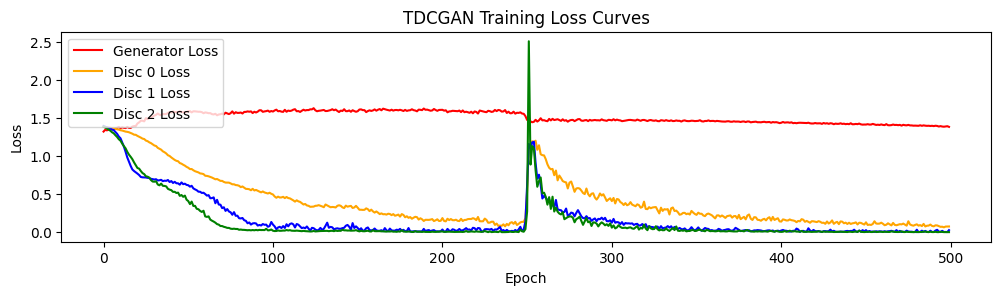

--- plot_3discs ---


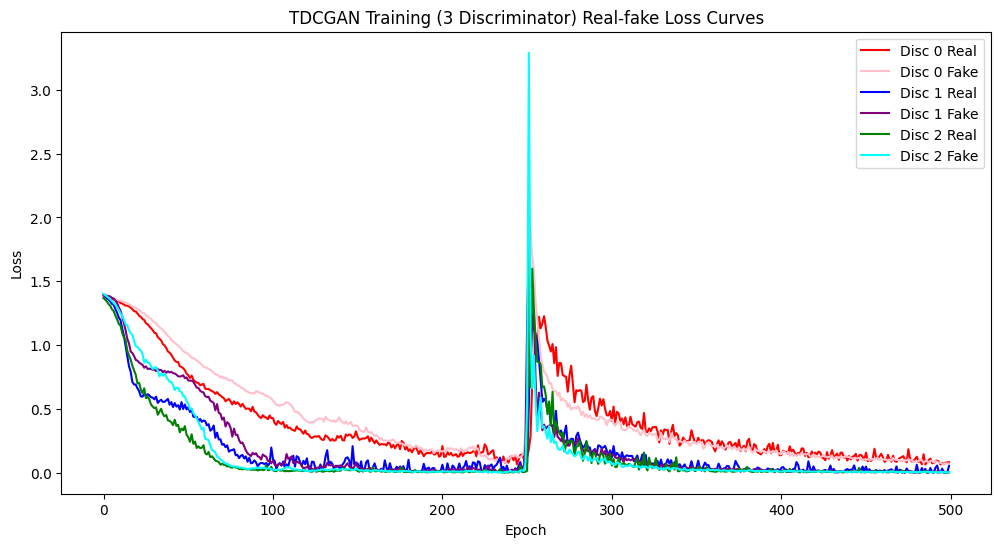

------------ Tokenization + stop word ( x_test ) ------------
sentences:  1200
tokens len: 1200
------------ TfidfVectorizer ( x_test ) ------------
Shape of X_tfidf :  (1200, 2755)
Training data TF-IDF features: 
     00  000   01  02169  03079   04   05  0esh6red32  0x28  0x2e  ...  zrgf  \
0  0.0  0.0  0.0    0.0    0.0  0.0  0.0         0.0   0.0   0.0  ...   0.0   
1  0.0  0.0  0.0    0.0    0.0  0.0  0.0         0.0   0.0   0.0  ...   0.0   
2  0.0  0.0  0.0    0.0    0.0  0.0  0.0         0.0   0.0   0.0  ...   0.0   
3  0.0  0.0  0.0    0.0    0.0  0.0  0.0         0.0   0.0   0.0  ...   0.0   
4  0.0  0.0  0.0    0.0    0.0  0.0  0.0         0.0   0.0   0.0  ...   0.0   

   ztkr  zurera  zuta  zxig  zxon  zxyw  zymq  zyvk  â¼n  
0   0.0     0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  
1   0.0     0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  
2   0.0     0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  
3   0.0     0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  
4   0.0     0.0

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 280, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'generator' (type Functional).
    
    Input 0 of layer "dense_512" is incompatible with the layer: expected axis -1 of input shape to have value 894, but received input with shape (None, 893)
    
    Call arguments received by layer 'generator' (type Functional):
      • inputs=['tf.Tensor(shape=(None, 892), dtype=float32)', 'tf.Tensor(shape=(None, 1), dtype=float32)']
      • training=False
      • mask=None


In [ ]:

""" ----------------- Apply Code ----------------- """


# ---------------------------> Read Data of CSV Files <--------------------------- #
dataset_directory = "/content/datasets"   #files_path
percent = 100
data = read_csv_files(dataset_directory,percent)
print('len data : ' , len(data))

class_Col = 'attack_type'
min_rows_per_class = 2000  #50000
origin_data = data

# >> ---------------------------> Balance Data Before Start <--------------------------- #
#df_balanced_before = balance_data_before_tdcgan(data, class_Col, min_rows_per_class)
#data = df_balanced_before


# ---------------------------> Apply pre-processing <--------------------------- #
main_text_col = 'sentence'
n_classes, X_train_copy, X_test_copy, y_train_copy, y_test_copy, \
n_components, X_train_final_df = preprocess_data(data, class_Col, 'x_train', main_text_col)


num_classes = n_classes # - 1
input_dim = X_train_final_df.shape[1]     # (features_dim) Dimensionality of TF-IDF vectors




# ---------------------------> Run TDCGAN Models (Gen., Disc., Comb.) <--------------------------- #
generator_model, discriminators_model, combined_model  = run_TDCGAN_models(input_dim, num_classes)



# ---------------------------> Train Model <--------------------------- #
batch_size = BATCH_SIZE       # 128

X_train = X_train_final_df
#print('ppp: ', X_train.shape)

train_22(BATCH_SIZE, input_dim, num_classes, generator_model, discriminators_model, combined_model,
        X_train_final_df, y_train_copy, NUM_EPOCHS)

"""
print('X_train shape' , X_train.shape)
print('y_train_copy shape' , y_train_copy.shape)

print('X_train head' , X_train.head)
print('y_train_copy head' , y_train_copy.head)

y_pred_combined_real = combined_model.predict([X_train, y_train_copy])
num_samples = 128 #len(y_train_copy)

print('--99 99--')
predicted_labels_real = np.argmax(y_pred_combined_real[0], axis=1)
predicted_real_vs_fake_combined = y_pred_combined_real[1]
print('--99 99 888--')


print('--88--')
# Print the classification report for the combined model on real data
print(f"{TextStyle.BOLD}\nClassification Report (Combined Model - Real Data - Class Prediction):{TextStyle.RESET_ALL}")
#print(classification_report(encoder.inverse_transform(y_test), encoder.inverse_transform(predicted_labels_real),zero_division=1))
print(classification_report(y_train_copy, predicted_labels_real, zero_division=1))

print(f"{TextStyle.BOLD}\nClassification Report (Combined Model - Real Data - Real vs. Fake Prediction):{TextStyle.RESET_ALL}")
print(classification_report(np.ones(num_samples), np.round(predicted_real_vs_fake_combined),zero_division=1))
"""








"""
# ---------------------------> Balance Data Using Generator of TDCGAN <--------------------------- #
df_origin_data = origin_data

df_2 = pd.DataFrame(X_train_copy)
cols = df_2.columns
df_2[class_Col] = y_train_copy
print('X_train_copy : ' , X_train_copy.head)
print('df_2 : ', df_2.head)

y_df = pd.DataFrame(y_train_copy)
print('y_train_copy : ' , y_train_copy.head)


all_df = pd.concat([df_2, y_train_copy])


input_dim = X_train_copy.shape[1]

# Identify the majority class and count
majority_class = df_2[class_Col].value_counts().idxmax()
majority_count = len(df_2[df_2[class_Col] == majority_class])

# Select only the minority classes data for training TDCGAN
minority_data = df_2[~df_2[class_Col].isin([majority_class])]
print('minority_data 1: ', minority_data.head)

labels_dic = (minority_data[class_Col].value_counts()).to_dict()

print('majority_class : ', majority_class)
print('majority_count : ', majority_count)
print('minority_data: ', minority_data)
print('labels_dic : ', labels_dic)
print('labels_dic len : ', len(labels_dic))

#Generate synthetic samples for the minority classes
print(f"{TextStyle.BOLD}Generate synthetic features and labels{TextStyle.RESET_ALL}")
for key, value in labels_dic.items():
  labels_dic[key]= majority_count - value
print('labels_dic 2 len : ', len(labels_dic))

synthetic_data = generate_synthetic_data(labels_dic, cols, class_Col, input_dim, generator_model)
print('synthetic_data : ', synthetic_data.head())

# Concatenate synthetic samples with the original dataset
new_data = pd.concat([df_2, synthetic_data], ignore_index=True, sort=False)
print('new_data shape' , new_data.shape)

#df_balanced_after = balance_data_using_generator(data, class_Col, min_rows_per_class, 'byModel',X_train, y_train, batch_size, input_dim)
#df_balanced_after = generate_new_data(X_train, y_train, batch_size, noise_dim)


# Concatenate synthetic samples with the original dataset
#synthetic_data = df_balanced_after
#new_data = pd.concat([df, synthetic_data], ignore_index=True, sort=False)
"""

# ---------------------------> X_test dataset in TDCGAN <--------------------------- #

#from sklearn.preprocessing import LabelEncoder

# Initialize OneHotEncoder
#encoder = LabelEncoder()
# Fit and transform the target column 'y'
#y_encoded = encoder.fit_transform(y)

#print('--99 7 s --')
#evaluate_on_real1(X_train_copy, y_train_copy, combined_model)  #encoder)
#print('--99 7 e --')



# ---------------------------> X_test dataset in TDCGAN <--------------------------- #
#import torch
#import torchvision

### ----- Apply pre-processing ----- ###
main_text_col = 'sentence'
X_test, y_test, n_components, X_test_final_df = preprocess_data_test(X_test_copy, y_test_copy)

# no. classes/category in class_Col (attack_type)
n_classes = y_test.nunique()
input_dim = X_test_final_df.shape[1]
num_samples = len(y_test)


generator_model, discriminators_model, combined_model  = run_TDCGAN_models(input_dim, n_classes)


batch_size = BATCH_SIZE       # 128
X_test = X_test_final_df
#train_22(BATCH_SIZE, input_dim, n_classes, generator_model, discriminators_model, combined_model,
#        X_test_final_df, y_test_copy, NUM_EPOCHS)

#y_test = pd.DataFrame(y_test, columns=[class_Col])

y_pred_combined_real = combined_model.predict([  X_test, y_test ])

print('--99 99--')
predicted_labels_real = np.argmax(y_pred_combined_real[0], axis=1)
predicted_real_vs_fake_combined = y_pred_combined_real[1]
print('--99 99 888--')

# Evaluate the combined model on real data
#X_test = torch.from_numpy(X_test)
#y_test = torch.from_numpy(y_test)

#import tensor as tf
#Considering y variable holds numpy array
#/y_test = tf.convert_to_tensor(y_test, dtype=tf.float64)


idx = np.random.randint(0, X_test.shape[0], batch_size)
X_test1 = X_test[idx]
y_test1 = y_test[idx]

print('x shape' , X_test.shape)
print('y shape' , y_test.shape)

"""
X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy()

print(f"X_test shape: {X_test_np.shape}")
print(f"y_test shape: {y_test_np.shape}")
"""
y_pred_combined_real = combined_model.predict([  X_test1, y_test1 ])
print('--99--')
predicted_labels_real = np.argmax(y_pred_combined_real[0], axis=1)
predicted_real_vs_fake_combined = y_pred_combined_real[1]

print('--88--')
# Print the classification report for the combined model on real data
print(f"{TextStyle.BOLD}\nClassification Report (Combined Model - Real Data - Class Prediction):{TextStyle.RESET_ALL}")
#print(classification_report(encoder.inverse_transform(y_test), encoder.inverse_transform(predicted_labels_real),zero_division=1))
print(classification_report(y_test, predicted_labels_real, zero_division=1))

print(f"{TextStyle.BOLD}\nClassification Report (Combined Model - Real Data - Real vs. Fake Prediction):{TextStyle.RESET_ALL}")
print(classification_report(np.ones(num_samples), np.round(predicted_real_vs_fake_combined),zero_division=1))



#performance = tdcgan_train_eval_full_balanced(data, X_test_copy, y_test_copy, encoder, name, "TDCGAN", class_Col, n_classes,
#                                X_test_copy.shape[1], 100, X_train_final_df, X_test_final_df)

#num_classes = X_test_copy.shape[1]
performance = tdcgan_train_eval_full_balanced(X_test_final_df, y_test, num_classes, input_dim, generator_model, discriminators_model, combined_model)

name_dataset = 'our_dataset'
classify(data, X_test_copy, y_test_copy, encoder, name_dataset, class_Col, "TDCGAN")









# **Other Models**

## **Stacking**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import StackingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_absolute_error, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

"""
def load_and_preprocess_data(pd_frames):
    tfidf_vectorizer = TfidfVectorizer(dtype='float32')
    tfidf_values = tfidf_vectorizer.fit_transform(pd_frames['sentence'])
    pd_frames.drop(columns=['sentence'], inplace=True)
    pd_frames['success attack (impact/effect)'] = pd_frames['success attack (impact/effect)'].astype(bool)
    pd_frames['type / status'] = pd_frames['type / status'].astype(int)
    return pd_frames['type / status'], tfidf_values
"""

def stacking_method(X_train, X_test, y_train, y_test):
    #Y, X = load_and_preprocess_data(pd_frames=frames)
    #X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
    base_models = [
        ('decision_tree', DecisionTreeClassifier()),
    ]
    stacking_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())
    stacking_model.fit(X_train, y_train)
    y_pred = stacking_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: ", accuracy)
    mae = mean_absolute_error(y_test, y_pred)
    print("Mean Absolute Error:", mae)
    # Calculate Precision score
    precision = precision_score(y_test, y_pred, average='macro')
    print("Precision:", precision)
    recall = recall_score(y_test, y_pred, average='macro')
    print("Recall:", recall)
    conf_matrix = confusion_matrix(y_test, y_pred)
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    TP = conf_matrix[1, 1]
    print("True Positives (TP):", TP)
    print("True Negatives (TN):", TN)
    print("False Positives (FP):", FP)
    print("False Negatives (FN):", FN)

## **Boosting**

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, mean_absolute_error, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

#from stacking import load_and_preprocess_data


def boosting_method(X_train, X_test, y_train, y_test): #(frames):
    #Y, X = load_and_preprocess_data(frames)
    #X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
    base_model = DecisionTreeClassifier()
    boosting_model = AdaBoostClassifier(base_model, n_estimators=10)
    boosting_model.fit(X_train, y_train)
    y_pred = boosting_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    mae = mean_absolute_error(y_test, y_pred)
    print("Mean Absolute Error:", mae)
    # Calculate Precision score
    precision = precision_score(y_test, y_pred, average='macro')
    print("Precision:", precision)
    recall = recall_score(y_test, y_pred, average='macro')
    print("Recall:", recall)
    conf_matrix = confusion_matrix(y_test, y_pred)
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    TP = conf_matrix[1, 1]
    print("True Positives (TP):", TP)
    print("True Negatives (TN):", TN)
    print("False Positives (FP):", FP)
    print("False Negatives (FN):", FN)

## **Bagging**

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, mean_absolute_error, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

#from stacking import load_and_preprocess_data


def bagging_method(X_train, X_test, y_train, y_test):
    #Y, X = load_and_preprocess_data(frames)
    #X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
    base_model = DecisionTreeClassifier()
    bagging_model = BaggingClassifier(base_model, n_estimators=10)
    bagging_model.fit(X_train, y_train)
    y_pred = bagging_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: ", accuracy)
    mae = mean_absolute_error(y_test, y_pred)
    print("Mean Absolute Error:", mae)
    # Calculate Precision score
    precision = precision_score(y_test, y_pred, average='macro')
    print("Precision:", precision)
    recall = recall_score(y_test, y_pred, average='macro')
    print("Recall:", recall)
    conf_matrix = confusion_matrix(y_test, y_pred)
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    TP = conf_matrix[1, 1]
    print("True Positives (TP):", TP)
    print("True Negatives (TN):", TN)
    print("False Positives (FP):", FP)
    print("False Negatives (FN):", FN)

## **ML Performance (Stacking)**

this with simple preprocess (Tfidf + split data 70/30)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import StackingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_absolute_error, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier


def load_and_preprocess_data(pd_frames):
    tfidf_vectorizer = TfidfVectorizer(dtype='float32')
    tfidf_values = tfidf_vectorizer.fit_transform(pd_frames['sentence'])
    pd_frames.drop(columns=['sentence'], inplace=True)
    pd_frames['len_payload'] = pd_frames['len_payload'].astype(int)
    pd_frames['attack_type'] = pd_frames['attack_type'].astype(int)

    X_train, X_test, y_train, y_test = train_test_split(tfidf_values, pd_frames['attack_type'], test_size=0.3, random_state=42)

    return X_train, X_test, y_train, y_test


def stacking_method(frames):
    X_train, X_test, y_train, y_test = load_and_preprocess_data(pd_frames=frames)
    #X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
    base_models = [
        ('decision_tree', DecisionTreeClassifier()),
    ]
    stacking_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())
    stacking_model.fit(X_train, y_train)
    y_pred = stacking_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: ", accuracy)
    mae = mean_absolute_error(y_test, y_pred)
    print("Mean Absolute Error:", mae)
    # Calculate Precision score
    precision = precision_score(y_test, y_pred, average='macro')
    print("Precision:", precision)
    recall = recall_score(y_test, y_pred, average='macro')
    print("Recall:", recall)
    conf_matrix = confusion_matrix(y_test, y_pred)
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    TP = conf_matrix[1, 1]
    print("True Positives (TP):", TP)
    print("True Negatives (TN):", TN)
    print("False Positives (FP):", FP)
    print("False Negatives (FN):", FN)


if __name__ == '__main__':
    dataset_directory = "/content/datasets"   #files_path
    percent = 100
    pd_frames = read_csv_files(dataset_directory,percent)
    print('len pd_frames : ' , len(pd_frames))

    #pd_frames = pd.read_csv("our_Dataset.csv")
    stacking_method(pd_frames)
    # pd_frames.sample(frac=1)
    # pd_frames.to_csv('newDataSet.csv', sep=',', encoding='utf-8')

# **TDCGAN (v2)**

## **libraries**

In [1]:
#for read csv file
import os
import pandas as pd
import numpy as np
import random


# pre-process
##for stop word
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

## not used now
#import unicodedata     # Remove accents
#import string

import sklearn

## for tokenization
from nltk.tokenize import word_tokenize
from nltk.tokenize import WordPunctTokenizer      ## WordPunctTokenizer --> splits words based on punctuation boundaries.

## for divide data to (train / test/ validate)
from sklearn.model_selection import train_test_split


# for one-hor encode (sentence to 2D)
from sklearn.preprocessing import OneHotEncoder

# for TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

# for TDCGAN
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Input,
    Concatenate,
    Embedding,
    Dense,
    LeakyReLU,
    BatchNormalization,
    Dropout,
    Reshape,
)

import keras
from keras.optimizers import Adam

# taqadum in arabic , progress/process in english
from tqdm.notebook import tqdm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:

print(tf. __version__)      # tensorflow version

!python --version           # python version

print(sklearn.__version__)         # scikit-learn version

print(keras.__version__)           # keras version

2.15.0
Python 3.10.12
1.2.2
2.15.0


## **definition**

In [3]:
NUM_DISCRIMINATORS = 3
GENERATOR_DROPOUT_RATE = 0.2  #0.1
DISCRIMINATOR_DROPOUT_RATE = 0.3      #Adjust the dropout rate to prevent overfitting during training.
LEAKY_RELU_ALPA = 0.2

NUM_EPOCHS = 500   #1000
BATCH_SIZE = 128
OPTIMIZER_LR = 0.0001                 # learning rate
OPTIMIZER_BETAS = (0.5, 0.999)

# Save losses for plotting
d0_real_losses = []   # left discriminator losses   (disc 0)
d0_fake_losses = []   # left discriminator losses   (disc 0)
d0_losses      = []   # discriminator losses        (disc 0)

d1_real_losses = []   # Middle discriminator losses (disc 1)
d1_fake_losses = []   # Middle discriminator losses (disc 1)
d1_losses      = []   # discriminator losses        (disc 1)

d2_real_losses = []   # right discriminator losses  (disc 2)
d2_fake_losses = []   # right discriminator losses  (disc 2)
d2_losses      = []   # discriminator losses        (disc 2)

g_losses       = []   # generator losses
d_losses       = []   # discriminator losses



# Suppress warnings from numpy
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)


## **Color list + TextStyle**

In [4]:
colors_list = [
    'Red', 'Green', 'Blue', 'Purple', 'Orange', 'Pink', 'Brown', 'Yellow',
    'Cyan', 'Magenta', 'Lime', 'Teal', 'Lavender', 'Maroon', 'Navy', 'Olive', 'Silver', 'Gold',
    'Indigo', 'Turquoise', 'Beige', 'Crimson', 'Salmon','Tan','Lime', 'Fuchsia', 'Plum',
    'Tomato', 'Violet']

class TextStyle:
    # Font Styles
    BOLD = '\033[1m'
    DIM = '\033[2m'
    UNDERLINE = '\033[4m'
    BLINK = '\033[5m'
    REVERSE = '\033[7m'
    RESET_ALL = '\033[0m'

    # Font Colors
    BLACK = '\033[30m'
    RED = '\033[31m'
    GREEN = '\033[32m'
    YELLOW = '\033[33m'
    BLUE = '\033[34m'
    MAGENTA = '\033[35m'
    CYAN = '\033[36m'
    WHITE = '\033[37m'

    # Background Colors
    BG_BLACK = '\033[40m'
    BG_RED = '\033[41m'
    BG_GREEN = '\033[42m'
    BG_YELLOW = '\033[43m'
    BG_BLUE = '\033[44m'
    BG_MAGENTA = '\033[45m'
    BG_CYAN = '\033[46m'
    BG_WHITE = '\033[47m'


## **Read Multi Files csv**

In [5]:
""" ----------------- Read CSV File Function ----------------- """
def read_csv_files(dataset_directory, percent):
  print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Handling Read CSV Files ------------{TextStyle.RESET_ALL}")

  files = [f for f in os.listdir(dataset_directory) if f.endswith('.csv')]

  if files == []:
    print('Not found any csv files')
  else:
    print('Your files are: ', files)

    np_array_values = []
    data_df = pd.DataFrame()
    firstFile = True

    for file in files:
      file_path = os.path.join(dataset_directory, file)   # csv_file_path
      print('File Path: ', file_path)

      try:
        df = ''
        df = pd.read_csv(file_path, encoding = "ISO-8859-1")  #.head()   #,low_memory=False   ISO-8859-1
        total_rows = len(df)
        print('Total rows in df/file: ', total_rows)

        num_rows = int(total_rows * (percent / 100))
        print('Total rows in df/file 100%: ', num_rows)


        """ Start From Teacher Code """
        # Generate a list of random indices
        random_indices = random.sample(range(total_rows), num_rows)
        #print('random_indices: ' , random_indices)

        # Select the random rows from the DataFrame
        temp_df = df.iloc[random_indices]
        if(firstFile):
          # Concatenate all DataFrames into one
          data_df = temp_df.copy()
          firstFile = False
        else:
          # Concatenate all DataFrames into one
          data_df = pd.concat([data_df,temp_df], ignore_index=True)

        print(data_df)
        return data_df
        """ End From Teacher Code """

        ## Add DataFrame to new CSV file
        #new_csv_file_path = os.path.join(dataset_directory, 'new_sqli.csv')  # "/content/dataset/new_sqli.csv"
        #df.to_csv(new_csv_file_path, index=False)

      except Exception as e:
        print('Can not Read File called : ', file)
        print('File path: ', file_path)
        print("Errpr Exception e : ", e)


#""" ----------------- Apply Code ----------------- """
#dataset_directory = "/content/datasets"   #files_path
#percent = 100
#data = read_csv_files(dataset_directory,percent)


## **one_hot_encoder**

In [36]:
## ----- one_hot_encoder_func ------ ##

def one_hot_encoder_func(X, one_hot_cols):
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Perform one-hot encoding ------------{TextStyle.RESET_ALL}")
    one_hot_encoded_df = X.copy()

    # Perform one-hot encoding
    one_hot_encoded_1 = pd.get_dummies(one_hot_encoded_df, columns=one_hot_cols, prefix=one_hot_cols)
    #print('one_hot_encoded : ', one_hot_encoded_1)

    # Get only columns that is original columns and needed as them + not neet to convert them from boolean to int
    origin_needed_cols = one_hot_encoded_1[[col for col in one_hot_encoded_1.columns if
                                            not any(col.startswith(col_name) for col_name in one_hot_cols)]]

    # Get only columns that created new by one-hoe-encoder (get_dummies)
    one_hot_cols_df = one_hot_encoded_1[[col for col in one_hot_encoded_1.columns if
                                          any(col.startswith(col_name) for col_name in one_hot_cols)]]

    # Convert one_hot_cols_df values from boolean to integers (1 and 0)
    one_hot_cols_df = one_hot_cols_df.astype(int)

    # Concatenate the one_hot_cols_df with the origin_needed_cols
    X = pd.concat([origin_needed_cols, one_hot_cols_df], axis=1)
    print('end one hot encoder : \n', X.head())

    """
      Ex of previous row:
          i  color  size              i     color_blue   color_red   size_M   size_S
          ---------------           ---------------------------------------------------
          0   red    S                0         0            1          0       1
          1   blue   M          ==>   1         1            0          1       0
          2   blue   S                2         1            0          0       1
    """

    return X


## **target_encode**

In [37]:
## ----- target_encode ------ ##

"""
  # target encoding/mean encoding
  # useful for encoding categorical features into numerical features based on their relationship with the target variable.
  # target_column : deciding it will depend on the objective of your analysis or model training.
  # It is typically the variable you're trying to predict in a supervised learning task.

  NOTE::
    Target-encode might not be ideal for SQL sentences
      1. SQL sentences are unstructured text data with potentially high cardinality and no inherent ordering.
      2. Target encoding works better for categorical variables with a clear relationship to the target,
          rather than free-form text.
"""
def target_encode(X, y, target_encode_cols, target_column):
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Perform target encoding ------------{TextStyle.RESET_ALL}")

    target_encoded_df = X.copy()
    print('target_encoded_df: ', target_encoded_df.head())

    # this colum choisen because it is needed to predict sentence is normal or sqli
    #target_column = class_Col # y   #encoding_col
    for col in target_encode_cols:

        # Check if the column exists
        if col not in X.columns:
            raise KeyError(f"Column '{col}' not found in DataFrame")

        # Concate y  --> class_Col to X now then next remove it
        #class_Col_df = y.copy()
        X = pd.concat([X, y], axis=1)

        # Calculate the mean target value for each category  (the mean float no for each category in column)
        mean_encoding = X.groupby(col)[target_column].mean()
        print('mean_encoding: ', mean_encoding.head())

        # Map the mean values back to the DataFrame
        target_encoded_df[col + '_encoded'] = X[col].map(mean_encoding)
        #print('target_encoded_df: ', target_encoded_df.head())

        # Drop class_Col added to do this part
        X = X.drop(target_column, axis=1)

        # Drop the original categorical column
        target_encoded_df = target_encoded_df.drop(col, axis=1)
        print('target_encoded_df: ', target_encoded_df.head())

        X = target_encoded_df

    return X



## **Pre-process**

In [39]:
from sklearn.preprocessing import LabelEncoder

##### work result 1 in png images
def load_and_preprocess_data(df_data):
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Pre-Proccess Data ------------{TextStyle.RESET_ALL}")

    # ----------- Check for NaN Values ------------- #
    print("Checking for NaN vallues ...")
    if df_data.isnull().values.any():
        print("NaN values found in the dataset. Handling missing values...")
        # Handling missing values by imputing with mean (you can choose other methods as well)
        df_data = df_data.fillna(df_data.mean())
    df_data.replace([np.inf, -np.inf,np.nan,np.NAN],0, inplace=True)

    if df_data.isnull().sum().sum() == 0 : # and np.isinf(df_data.values).sum() == 0 :
        print('Done Handling missing values')


    # ----------- lowercase + strip 'sentence' ------------- #
    # Convert to lowercase & Remove spaces in start and end
    df_data['sentence'] = df_data['sentence'].str.lower().str.strip()


    # ------------------------------------  separate target from predictors ------------------------------------ #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}separate target from predictors{TextStyle.RESET_ALL}")

    class_Col = 'attack_type'
    df_data['len_payload'] = df_data['len_payload'].astype(int)
    df_data[class_Col] = df_data[class_Col].astype(int)     #pd_frames['attack_type'] = pd_frames['attack_type'].astype(int)
    y = df_data[class_Col]      # main col to classify at end (class_Col --> attack_type)
    n_classes = y.nunique()      # no. classes/category in class_Col (attack_type)     n_classes = pd_frames['attack_type'].nunique()

    """ Start New track
    ##$$ track 1
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}Encode categorical labels using Label Encoder {TextStyle.RESET_ALL}")
    encoder = LabelEncoder()                  # Initialize OneHotEncoder
    y_encoded = encoder.fit_transform(y)      # Fit and transform the target column 'y'
    End New track """


    # ------------------------------------ TfidfVectorizer train data ------------------------------------ #
    tfidf_vectorizer = TfidfVectorizer(dtype='float32')
    X_tfidf_values = tfidf_vectorizer.fit_transform(df_data['sentence'])
    X_tfidf_selected_features = tfidf_vectorizer.get_feature_names_out()
    df_data.drop(columns=['sentence'], inplace=True)


    # ------------------------------------ train_test_split ------------------------------------ #
    # Divide the dataset into training (70%) and testing (30%)
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}---------------- Divide the dataset into training (70%) and testing (30%) ----------------{TextStyle.RESET_ALL}")
    X_train, X_test, y_train, y_test = train_test_split(X_tfidf_values, df_data['attack_type'], test_size=0.3, random_state=42)
    """ Start New track
    ##$$ track 1
    X_train, X_test, y_train, y_test = train_test_split(X_tfidf_values, y_encoded, test_size=0.3, random_state=42)
    End New track """

    X_train = pd.DataFrame(X_train.toarray(), columns=X_tfidf_selected_features)
    X_test  = pd.DataFrame(X_test.toarray(),  columns=X_tfidf_selected_features)
    y_train = pd.DataFrame(y_train, columns=['attack_type'])
    y_test  = pd.DataFrame(y_test,  columns=['attack_type'])

    X_train = X_train.reset_index(drop=True)
    X_test  = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test  = y_test.reset_index(drop=True)

    return n_classes, X_train, X_test, y_train, y_test#,, encoder
    """ Start New track
    ##$$ track 1
    return n_classes, X_train, X_test, y_train, y_test, encoder
    End New track """






def load_and_preprocess_data1(df_data):
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Pre-Proccess Data ------------{TextStyle.RESET_ALL}")

    # ----------- Check for NaN Values ------------- #
    print("Checking for NaN vallues ...")
    if df_data.isnull().values.any():
        print("NaN values found in the dataset. Handling missing values...")
        # Handling missing values by imputing with mean (you can choose other methods as well)
        df_data = df_data.fillna(df_data.mean())
    df_data.replace([np.inf, -np.inf,np.nan,np.NAN],0, inplace=True)

    if df_data.isnull().sum().sum() == 0 : # and np.isinf(df_data.values).sum() == 0 :
        print('Done Handling missing values')


    # ----------- lowercase + strip 'sentence' ------------- #
    # Convert to lowercase & Remove spaces in start and end
    df_data['sentence'] = df_data['sentence'].str.lower().str.strip()



    # ------------------------------------  separate target from predictors ------------------------------------ #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}separate target from predictors{TextStyle.RESET_ALL}")

    class_Col = 'attack_type'

    df_data['len_payload'] = df_data['len_payload'].astype(int)
    df_data[class_Col] = df_data[class_Col].astype(int)     #pd_frames['attack_type'] = pd_frames['attack_type'].astype(int)
    y = df_data[class_Col]      # main col to classify at end (class_Col --> attack_type)
    n_classes = y.nunique()      # no. classes/category in class_Col (attack_type)     n_classes = pd_frames['attack_type'].nunique()


    # remove y column (class_Col) from data columns list (df_data)
    df_data.drop([class_Col], axis=1, inplace=True)           # comment prev. 10:00 - 19-5-2024

    X = df_data.copy()
    X_columns = X.columns       #['sentence', 'len_payload', ....]



    # ------------------------------------ Apply encoding for categorical columns if any ------------------------------------ #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}Handling Categorical Features{TextStyle.RESET_ALL}")
    # all categorical columns (any column with object dataType ant its value not number)
    categorical_cols = [cname for cname in X.columns if
                        X[cname].dtype == "object"]
    print("Categorical columns len: ", len(categorical_cols))
    print("Categorical columns: ", categorical_cols)

    # Columns that will be one-hot encoded
    # X[cname].nunique() < 4   : less that 4 categories in the column
    one_hot_cols = [cname for cname in X.columns if
                      X[cname].nunique() < 4 and
                      X[cname].dtype == "object"]
    print('one_hot_cols : ', one_hot_cols)
    print("No. Columns need to encoded using one-hot-encoding: ", len(one_hot_cols))

    # Skip this columns because it needs to use TfidFVectorizer With it
    skip_cols = [main_text_col]

    # Columns that will be target encoded  (will get columns with more than 4 categories in it :: like 'sentence' column)
    target_encode_cols = list(set(categorical_cols)-set(one_hot_cols) - set(skip_cols) )
    print('target_encode_cols : ', target_encode_cols)
    print("No. Columns need to encoded using target-encoding: ", len(target_encode_cols))


    # Encode categorical columns if there is any
    if(len(categorical_cols) > 0):

      # to perform one-hot encoding on specified columns of a DataFrame.
      if(len(one_hot_cols)> 0):
        X = one_hot_encoder_func(X, one_hot_cols)

      if(len(target_encode_cols) > 0):
        target_column = class_Col
        X = target_encode(X, y, target_encode_cols, target_column)

    else:
      print("No categorical columns, nothing todo")




    # ------------------------------------ train_test_split ------------------------------------ #
    # Divide the dataset into training (70%) and testing (30%)
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}---------------- Divide the dataset into training (70%) and testing (30%) ----------------{TextStyle.RESET_ALL}")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



    # ------------------------------------ TfidfVectorizer train data ------------------------------------ #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}---------------- TfidfVectorizer ----------------{TextStyle.RESET_ALL}")
    tfidf_vectorizer = TfidfVectorizer(dtype='float32')

    X_tfidf_values = tfidf_vectorizer.fit_transform(X_train['sentence']) #X_train)
    X_tfidf_selected_features = tfidf_vectorizer.get_feature_names_out()
    #pd_frames.drop(columns=['sentence'], inplace=True)

    X_test_tfidf_values = tfidf_vectorizer.transform(X_test['sentence']) #X_test)
    X_test_tfidf_selected_features = tfidf_vectorizer.get_feature_names_out()

    origin_x_train = X_train
    origin_x_test = X_test
    X_train.drop(columns=['sentence'], inplace=True)
    X_test.drop(columns=['sentence'], inplace=True)

    # Concatenate TF-IDF features with the original data excluding the sentence column
    X_train = pd.concat([X_train, X_tfidf_values], axis=1)    #.drop(['sentence'], axis=1)
    X_test = pd.concat([X_test, X_test_tfidf_values], axis=1)

    X_train = pd.DataFrame(X_train.toarray(), columns=X_tfidf_selected_features)
    X_test  = pd.DataFrame(X_test.toarray(),  columns=X_test_tfidf_selected_features)
    y_train = pd.DataFrame(y_train, columns=['attack_type'])
    y_test  = pd.DataFrame(y_test,  columns=['attack_type'])

    X_train = X_train.reset_index(drop=True)
    X_test  = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test  = y_test.reset_index(drop=True)



    # ------------------------------------ MinMaxScaler ------------------------------------ #
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Scaling Features using 'MinMaxScaler' ------------{TextStyle.RESET_ALL}")
    scaler = MinMaxScaler()

    X_train_scaled = scaler.fit_transform(X_train, axis=1)
    X_test_scaled = scaler.transform(X_test, axis=1)

    # Convert the scaled numerical features back to DataFrames
    X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)



    # ------------------------------------ PCA for feature selection ------------------------------------ #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ PCA ------------{TextStyle.RESET_ALL}")
    import matplotlib.pyplot as plt
    import pandas as pd
    from sklearn.decomposition import PCA
    from sklearn import preprocessing
    from sklearn.preprocessing import StandardScaler, MinMaxScaler

    n_components = 0.95
    #X_train_final_df = simple_perform_pca_new(n_components, 'x_train', X_train_scaled_df , y_train_copy )
    #X_final_df = X_train_final_df

    # Fit & Transform PCA on the training data
    pca = PCA(n_components=n_components, random_state=453)
    #print('pca: ' , pca)

    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Convert PCA results back to DataFrames and concatenate with the original non-sentence columns
    # Generate new feature names for PCA components
    train_pca_feature_names = [f'pca_{i+1}' for i in range(X_train_pca.shape[1])]
    X_train_pca_df = pd.DataFrame(data=X_train_pca, columns=train_pca_feature_names)      # Create a DataFrame with the PCA-transformed data

    test_pca_feature_names = [f'pca_{i+1}' for i in range(X_test_pca.shape[1])]
    X_test_pca_df = pd.DataFrame(data=X_test_pca, columns=test_pca_feature_names)         # Create a DataFrame with the PCA-transformed data

    # Combine the PCA-transformed features with the target variable
    X_train = pd.concat([X_train_pca_df, y_train], axis=1)
    X_test  = pd.concat([X_test_pca_df, y_test], axis=1)



    return n_classes, X_train, X_test, y_train, y_test



## **Implement TDCGAN Models**

### **build_generator**

The model of the generator is a deep multi-layer perceptron (MLP) composed of an input layer, output layer and four hidden layers. Initially, the generator takes a point from the latent space to generate new data. The latent space is a multi-dimensional hypersphere normal distributed points, where each variable is drawn from the distribution of the data in the dataset. An embedded layer in the generator creates a vector representation for the generated point.
The generator model has four hidden layers. The first one is composed of 256 neurons with a rectified linear unit (ReLU) activation function. An embedded layer is used between hidden layers to efficiently map input data from a high-dimension to lower-dimension space. This allows the neural network to learn the data relationship and process it efficiently. The second hidden layer consists of 128 neurons, the third has 64 neurons and the last one has 32 neurons, with the ReLU activation function used with them all, and a regularization dropout of 20% is added to avoid overfitting. The output layer is activated using the Softmax activation function with 14 neurons as the number of features in the dataset.

In [7]:
"""
Creates a generator model for text generation using a deep MLP.

Args:
    input_dim  : The dimension of the latent space.  (latent_dim)
    num_classes: The size of the vocabulary (number of unique words).  ((get it by tokeniz))  (vocabulary_size)
    GENERATOR_DROPOUT_RATE : it is 20% ==> 0.2

Returns:
    A TensorFlow Keras model representing the text generation GAN generator.
"""
def build_generator(input_dim, num_classes):   # vocabulary_size / num_class
  print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ build_generator ------------{TextStyle.RESET_ALL}")

  GENERATOR_DROPOUT_RATE = 0.2

  # Input layers for data (real or generated) and label
  # our data is Conditional Generation so label is needed
  noise = Input(shape=(input_dim,), name='noise')    # latent space noise (Features , ex: 100 samples, 10 features)
  label = Input(shape=(num_classes,), name='label')  # no need for One-hot encoded label, its numeric
  print('len noise: ', noise.shape[1])

  #concatenated = Concatenate()([data, label])
  # Concatenate features and label  (Concatenate along the last dimension)
  """  Concatenation: A Concatenate layer is used to combine the features and label along the last dimension (axis=-1).
      This creates a single input for the subsequent hidden layers in the discriminator model."""
  concatenated = Concatenate()([noise, label])   #Concatenate(axis=-1) is defualt

  # Embedded layer to map noise to lower-dimensional space
  # It creates a vector representation for the generated point.
  hidden = Embedding(input_dim, num_classes // 2)(concatenated)  # Adjust embedding dim as needed

  # Hidden layers with ReLU activation and dropout
  hidden = Dense(256, activation='relu')(concatenated)  #(hidden)
  hidden = Dropout(GENERATOR_DROPOUT_RATE)(hidden)

  hidden = Dense(128, activation='relu')(hidden)
  hidden = Dropout(GENERATOR_DROPOUT_RATE)(hidden)

  hidden = Dense(64, activation='relu')(hidden)
  hidden = Dropout(GENERATOR_DROPOUT_RATE)(hidden)

  hidden = Dense(32, activation='relu')(hidden)
  hidden = Dropout(GENERATOR_DROPOUT_RATE)(hidden)

  # Output layer with Softmax activation
  generated_text = Dense(input_dim, activation='softmax', name='generated_text')(hidden)
  print('generated_text shape: ', generated_text.shape)

  # Create the generator model
  generator_model = Model(inputs=[noise, label], outputs=generated_text, name='generator')

  generator_model.compile(
      loss='binary_crossentropy',
      optimizer=Adam(learning_rate= 0.0002 , beta_1= 0.5),
      metrics=['accuracy']
  )

  return generator_model

### **build_discriminator**

In the TDCGAN architecture consists of three discriminators. Each discriminator is a deep neural network with different architecture and different parameter settings. Each discriminator’s role is to extract features from the output of the generator and classify the data with varying levels of accuracy for each them. The model aims to classify data into two groups: normal flows for the background traffic with 0 representation, and anomaly flows for the attack data with 1 representation. The discriminator distinguishes the new data generated by the generator from the true data distribution. It classifies them as either real or fake. Subsequently, the discriminator undergoes updates to improve its ability to distinguish between real and fake samples in the subsequent round. The discriminators try to classify the data into their corresponding class, which is done through a fully connected MLP network.

Each discriminator is a MLP model with a different number of hidden layers, different number of neurons and different dropout percentage. The first discriminator is composed of 3 hidden layers with 100 neurons for each and 10% dropout regularization. The second has five hidden layers with 64, 128, 256, 512, and 1024 neurons for each layer, respectively. The dropout percentage is 40%. The last discriminator has 4 hidden layers with 512, 256, 128, and 64 neurons for each layer and 20% dropout percentage.
The LeakyReLU(alpha = 0.2) is used as an activation function for the hidden layers in the discriminators. Two output layers are used for each discriminator with the Softmax function as an activation function for one output layer and the Sigmoid activation function for the second output layer.

***Why 3 discriminator?***

In this model, three discriminators are used and each discriminator haas different architecture. These considered a modified training strategy which helped to face challenge in detection tasks. So, it help the generator to reach its optimal state even when the discriminator converges quickly during the initial stages of training.


In [8]:
import keras.backend as K

"""
Creates a discriminator model for TDCGAN with specified architecture.

Args:
    input_dim         : Dimensionality of the data features (based on your data size)
    num_classes       : Number of classes in the dataset (maybe - num_attack_classes)
    name              : Name for the discriminator model.
    num_hidden_layers : Number of hidden layers in the discriminator.
    neurons_per_layer : List of integers specifying the number of neurons in each hidden layer.
    dropout_rate      : Dropout rate for regularization.

Returns:
    A TensorFlow Keras model representing the TDCGAN discriminator.
"""

def build_discriminator(input_dim, num_classes, name, num_hidden_layers, neurons_per_layer, dropout_rate):
  print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ build_discriminator (", name , f") ------------{TextStyle.RESET_ALL}")

  # Input layers for data (real or generated) and label
  # our data is Conditional Generation so label is needed
  data  = Input(shape=(input_dim,), name='data')       # Features    (ex: 100 samples, 10 features)
  label = Input(shape=(num_classes,), name='label')   # Tf-IDF Vectorizer not One-hot encoded label
  print('len data: ', data.shape[1])
  # Concatenate features and label  (Concatenate along the last dimension)
  """  Concatenation: A Concatenate layer is used to combine the features and label along the last dimension (axis=-1).
      This creates a single input for the subsequent hidden layers in the discriminator model."""
  concatenated = Concatenate()([data, label])   #Concatenate(axis=-1) is defualt

  # Hidden layers with LeakyReLU activation and dropout
  # These layers extract the features
  hidden = data
  for i in range(num_hidden_layers):
    if i == 0:
      #hidden = Dense(neurons_per_layer[i], activation='leaky_relu', alpha=0.2)(concatenated)
      hidden = Dense(neurons_per_layer[i])(concatenated)
      hidden = LeakyReLU(alpha=0.2)(hidden)
      hidden = Dropout(dropout_rate)(hidden)
    else:
      #hidden = Dense(neurons_per_layer[i], activation='leaky_relu', alpha=0.2)(hidden)
      hidden = Dense(neurons_per_layer[i])(hidden)
      hidden = LeakyReLU(alpha=0.2)(hidden)
      hidden = Dropout(dropout_rate)(hidden)
      # Consider adding for training stability (important) but this will make disc summary non-trainable params != 0
      #hidden = BatchNormalization()(hidden)

  ## Flatten ?!

  # Output layer for real vs fake prediction (Real/fake classification)
  validity_output = Dense(1, activation='sigmoid', name='validity_output')(hidden)

  # Output layer for class label prediction (normal/sqli attack classification)   (Auxiliary classification / class_output)
  auxiliary_output = Dense(num_classes, activation='softmax', name='auxiliary_output')(hidden)

  print('ttsm - real/fake validity_output : ', validity_output)
  print('ttsm - normal/sqli auxiliary_output : ', auxiliary_output)
  print('ttsm - real/fake validity_output value : ', K.print_tensor(validity_output, message='K1 = '))
  print('ttsm - normal/sqli auxiliary_output value : ', K.print_tensor(auxiliary_output, message='K2 = '))

  # Build and compile the discriminator model
  discriminator_model = Model(inputs=[data, label], outputs=[auxiliary_output, validity_output], name=name)    # inputs=data

  # auxiliary_output (attack_type maybe) may binary_crossentropy  (0 --> normal / 1 --> SQLi)
  #'auxiliary_output': 'categorical_crossentropy', // binary_crossentropy
  discriminator_model.compile(
      loss={'auxiliary_output': 'categorical_crossentropy', 'validity_output': 'binary_crossentropy'},
      optimizer=Adam(learning_rate= 0.0002 , beta_1= 0.5),
      metrics={'auxiliary_output': 'accuracy', 'validity_output': 'accuracy'})

  return discriminator_model



  """ ----------------- Apply Discriminater with req. values ------------------ """
  # Define discriminator architectures
  #discriminator_1 = create_discriminator(2, 'discriminator_1', 3, [100, 100, 100], 0.1)
  #discriminator_2 = create_discriminator(2, 'discriminator_2', 5, [64, 128, 256, 512, 1024], 0.4)
  #discriminator_3 = create_discriminator(2, 'discriminator_3', 4, [512, 256, 128, 64], 0.2)

  """
  # May used in training as EX
  # Example Data (assuming you have 3 classes and input_dim is 10)
  real_data = tf.random.normal(shape=(100, 10))  # Sample real data (100 samples, 10 features)
  label_one_hot = tf.one_hot(tf.random.uniform(shape=(100,), minval=0, maxval=num_classes, dtype=tf.int32), depth=num_classes)  # One-hot encoded labels (100 samples)
  """


### **Election Layer**

In [9]:
from tensorflow.keras.layers import Lambda

# Election Layer
def election_layer(discriminators_outputs):
    def majority_vote(logits):
        votes = tf.reduce_sum(logits, axis=0)
        ### votes = tf.reduce_sum(logits)  #.numpy()      ## try this

        # use argmax to finds the index of the maximum value in the summed logits vector.
        # This index corresponds to the class with the highest combined vote.
        #xx = tf.round(tf.argmax(votes, axis=-1))

        return votes

    print('election 0')
    # Stack the discriminator outputs along the last axis
    class_outputs_stack = Lambda(lambda x: tf.stack(x, axis=0))(discriminators_outputs['class'])
    validity_outputs_stack = Lambda(lambda x: tf.stack(x, axis=0))(discriminators_outputs['validity'])

    # Unpack the class and validity outputs from each discriminator
    #class_outputs = [output[0] for output in discriminators_outputs]
    #validity_outputs = [output[1] for output in discriminators_outputs]


    # Ensure that we do not calculate mean on an empty tensor
    if class_outputs_stack.shape[0] == 0:
        raise ValueError("Class outputs stack is empty.")
    if validity_outputs_stack.shape[0] == 0:
        raise ValueError("Validity outputs stack is empty.")


    # Perform majority voting
    #class_output = Lambda(lambda x: majority_vote(x), name='comb_class_output')(class_outputs_stack)  # election_class_output
    #validity_output = Lambda(lambda x: majority_vote(x), name='comb_validity_output')(validity_outputs_stack)  # election_validity_output

    print('election 1')
    # Perform majority voting by averaging the stacked outputs
    class_output = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=0), name='comb_class_output')(class_outputs_stack)   # election_class_output
    validity_output = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=0), name='comb_validity_output')(validity_outputs_stack)  # election_validity_output

    # Calculate the majority vote for class outputs
    #class_output = Lambda(lambda x: majority_vote(x), name='comb_class_output')(class_outputs_stack)

    # Calculate the mean of the validity outputs
    #validity_output = Lambda(lambda x: tf.reduce_mean(x, axis=0), name='comb_validity_output')(validity_outputs_stack)


    # Return the rounded average as the final decision (0 or 1)
    #class_output = tf.cast( tf.round(class_output) , tf.int64)
    #validity_output = tf.cast( tf.round(validity_output) , tf.int64)
    print('election 3')
    return class_output, validity_output




def election_layer_old(discriminators_outputs):
    concatenated_class_outputs = Concatenate()(discriminators_outputs['class'])         # auxiliary_output
    concatenated_validity_outputs = Concatenate()(discriminators_outputs['validity'])   # validity_output

    class_output = Dense(discriminators_outputs['class'][0].shape[-1], activation='softmax', name='election_class_output')(concatenated_class_outputs)
    validity_output = Dense(1, activation='sigmoid', name='election_validity_output')(concatenated_validity_outputs)

    return class_output, validity_output



***class***

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class ElectionLayer(Layer):
    def __init__(self, **kwargs):
        super(ElectionLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Inputs will be a list of outputs from the three discriminators
        d1_output, d2_output, d3_output = inputs

        # Stack the discriminator outputs along the last axis
        stacked_outputs = tf.stack([d1_output, d2_output, d3_output], axis=-1)

        # Perform majority voting by averaging the stacked outputs
        majority_vote = tf.reduce_mean(stacked_outputs, axis=-1)

        # Return the rounded average as the final decision (0 or 1)
        return tf.round(majority_vote)

    def compute_output_shape(self, input_shape):
        return input_shape[0][:-1]

### **create_combined_model**

In [11]:

def build_combined_model(input_dim, num_classes, generator_model, discriminators_model):
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ build_combined_model ------------{TextStyle.RESET_ALL}")

    print('comb 0')
    # functional API model has its input shape, it is suited for more complex models, accepting branches, concatenations, etc.
    #noise = Input(shape=(input_dim,))
    noise_data  = Input(shape=(input_dim,), name='noise_data')
    labels = Input(shape=(num_classes,), name='labels')
    print('labels sm : ', labels)

    # Generator output features for the discriminator
    generated_data = generator_model([noise_data, labels])      # generated_features


    print('comb 1')
    """ With loop (num of Disc. (3 Disc)  ) """

    # Define list for Discriminator outputs for the generated data
    discriminators_class_outputs =[]
    discriminators_validity_outputs =[]

    # another way (not in loop) see -->  ##### Comment 1 #####

    for discriminator in discriminators_model:
        # Freeze discriminator
        # (Freeze Trainable Parameters) -> this make lots params non-trainable
        # For the combined model, we only train the generator (disable discriminator training) for all 3 Discr.
        discriminator.trainable = False

        # Discriminator Output for (class label prediction) and (validity --> real vs fake prediction)
        class_outputs , validity_outputs = discriminator([generated_data, labels])
        discriminators_class_outputs.append(class_outputs)
        discriminators_validity_outputs.append(validity_outputs)

        #print('class_outputs ', class_outputs )
        #print('shap disc class output (class[0] layers [1]): ', discriminators_outputs['class'][0].get_layer().output )


    discriminators_outputs = {
                                'class': discriminators_class_outputs,
                                'validity': discriminators_validity_outputs
                            }


    """ ------- Election Layer ------- """
    # discriminators_outputs[class][0]  => discriminator 0 , [1] disc 1 , [2] disc 2
    print('comb 2')
    print('shap disc class output discriminators_outputs[class]: ', discriminators_outputs['class'] )
    print('shap disc class output discriminators_outputs[class][0]: ', discriminators_outputs['class'][0] )
    print('shap disc class output: ', discriminators_outputs['class'][0].shape[-1] )



    print('discriminators_outputs : ', discriminators_outputs)
    #class_output, validity_output = election_layer(discriminators_outputs)

    #election_layer_class = ElectionLayer()(discriminators_class_outputs)
    #election_layer_validity = ElectionLayer()(discriminators_validity_outputs)

    """"""
    print('comb 3')
    # Concatenate discriminators outputs
    concatenated_discriminator_class_outputs = Concatenate()(discriminators_class_outputs)
    concatenated_discriminator_validity_outputs = Concatenate()(discriminators_validity_outputs)

    print('comb 4')
    # Output for class label prediction
    class_output = Dense(num_classes, activation='softmax', name='comb_class_output')(concatenated_discriminator_class_outputs)

    # Output for real vs fake prediction
    validity_output = Dense(1, activation='sigmoid', name='comb_validity_output')(concatenated_discriminator_validity_outputs)


    # Apply Election Layer to get the final majority vote
    #election_class_output = ElectionLayer(name='election_class_output')([class_outputs for class_outputs in discriminators_class_outputs])
    #election_validity_output = ElectionLayer(name='election_validity_output')([validity_outputs for validity_outputs in discriminators_validity_outputs])



    # Perform the election using tf.reduce_max (can also use other combining strategies)
    ##$class_output = tf.reduce_max(tf.stack(discriminators_outputs['class'], axis=-1), axis=-1)
    ##$validity_output = tf.reduce_max(tf.stack(discriminators_outputs['validity'], axis=-1), axis=-1)




    print('comb 5')
    # Build the combined model
    combined_model = Model(inputs=[noise_data, labels],outputs=[class_output,validity_output], name='Combined_Model_TDCGAN')
    print('comb 6')

    combined_model.compile(
        loss={'comb_class_output': 'categorical_crossentropy', 'comb_validity_output': 'binary_crossentropy'},  # categorical_crossentropy
        optimizer = Adam(learning_rate=0.0002, beta_1=0.5),
        metrics={'comb_class_output': 'accuracy', 'comb_validity_output': 'accuracy'}  #['accuracy']  #
    )
    print(77)

    return combined_model





    """
    ##### Comment 1 #####

    # --------> Disc 0 <------- #
    # Freeze discriminator
    # For the combined model, we only train the generator (disable discriminator training) for all 3 Discr.
    discriminators_model[0].trainable = False

    # create_discriminator(data_dim, num_classes, name, num_hidden_layers, neurons_per_layer, dropout_rate):
    class_outputs_0 , validity_outputs_0 = discriminators_model[0]([generated_data, labels])
    discriminators_class_outputs.append(class_outputs_0)
    discriminators_validity_outputs.append(validity_outputs_0)
    print('class_outputs 0 : ', class_outputs_0)
    print('validity_outputs 0 : ', validity_outputs_0)


    # --------> Disc 1 <------- #
    # Freeze discriminator
    # For the combined model, we only train the generator (disable discriminator training) for all 3 Discr.
    discriminators_model[1].trainable = False

    # create_discriminator(data_dim, num_classes, name, num_hidden_layers, neurons_per_layer, dropout_rate):
    class_outputs_1 , validity_outputs_1 = discriminators_model[1]([generated_data, labels])
    discriminators_class_outputs.append(class_outputs_1)
    discriminators_validity_outputs.append(validity_outputs_1)
    print('class_outputs 1 : ', class_outputs_1)
    print('validity_outputs 1 : ', validity_outputs_1)

    # --------> Disc 2 <------- #
    # Freeze discriminator
    # For the combined model, we only train the generator (disable discriminator training) for all 3 Discr.
    discriminators_model[2].trainable = False

    # create_discriminator(data_dim, num_classes, name, num_hidden_layers, neurons_per_layer, dropout_rate):
    class_outputs_2 , validity_outputs_2 = discriminators_model[2]([generated_data, labels])
    discriminators_class_outputs.append(class_outputs_2)
    discriminators_validity_outputs.append(validity_outputs_2)
    print('class_outputs 2 : ', class_outputs_2)
    print('validity_outputs 2 : ', validity_outputs_2)

    class_output = class_outputs_2
    validity_output = validity_outputs_2

    """

### **print_models_summary**

In [12]:
def print_models_summary(generator_model, combined_model, discriminators_model):
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Print Summary ------------{TextStyle.RESET_ALL}")


    print(f"{TextStyle.BOLD}{TextStyle.BLUE}\nGenerator summary (TDCGAN): \n{TextStyle.RESET_ALL}")
    generator_model.summary(show_trainable=True,expand_nested=True)


    print(f"{TextStyle.BOLD}{TextStyle.BLUE}\nDiscriminators summary (TDCGAN): \n{TextStyle.RESET_ALL}")

    i = 1
    for discriminator in discriminators_model:
        print(f"{TextStyle.BOLD}\nDiscriminator " , i , f" summary (TDCGAN):{TextStyle.RESET_ALL} ")
        discriminator.summary(show_trainable=True,expand_nested=True)
        i = i + 1


    print(f"{TextStyle.BOLD}{TextStyle.BLUE}\nCombined_model summary (TDCGAN):\n{TextStyle.RESET_ALL} ")
    combined_model.summary(show_trainable=True)


### **plot_architecture (not wok)**

In [13]:
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

def plot_architecture(generator_model, discriminators_model, combined_model):

    # Create a single row of 6 subplots
    fig, axes = plt.subplots(6, 1, figsize=(10, 40))
    path = '/content/datasets/assets/'

    # Plot Generator Architecture
    #print(path+'generator.png')
    file_name = os.path.join(path, 'generator.png')
    plot_model(generator_model, to_file=file_name, show_shapes=True, show_layer_names=True,show_trainable=True,expand_nested=True)
    img = plt.imread('generator.png')
    axes[0].imshow(img)
    axes[0].axis('off')
    axes[0].set_title('TDCGAN Generator Architecture')

    # Plot Discriminator Architecture

    i = 0
    axes_idx = 1
    for discriminator in discriminators_model:
      disc_name = path + 'discriminator_' + i + '.png'
      file_name = os.path.join(path, disc_name)
      plot_model(discriminator, to_file=file_name, show_shapes=True, show_layer_names=True,show_trainable=True,expand_nested=True)
      img = plt.imread(disc_name)
      axes[axes_idx].imshow(img)
      axes[axes_idx].axis('off')
      i = i + 1
      axes[axes_idx].set_title('TDCGAN Discriminator ' + i + ' Architecture')
      axes_idx = axes_idx + 1

    # Plot Combined Architecture
    file_name = os.path.join(path, 'combined.png')
    plot_model(combined_model, to_file=file_name, show_shapes=True, show_layer_names=True,show_trainable=True,expand_nested=True)
    img = plt.imread('combined.png')
    axes[4].imshow(img)
    axes[4].axis('off')
    axes[4].set_title('TDCGAN Combined Architecture')

    # Plot Combined Architecture
    file_name = os.path.join(path, 'combined2.png')
    plot_model(combined_model, to_file=file_name, show_shapes=True, show_layer_names=True,show_trainable=True)
    img = plt.imread('combined2.png')
    axes[5].imshow(img)
    axes[5].axis('off')
    axes[5].set_title('TDCGAN Combined 2 Architecture')

    #plt.show()


## **Train**

In [23]:
import time

# input_dim = latent_dim = noise_dim

def train_model(batch_size, noise_dim, num_classes, generator_model, discriminators_model, combined_model,
          X_train, y_train, NUM_EPOCHS):

  #X_train = np.array(X_train)  #.values.tolist()   #.toarray()  #to_numpy()   #csr_matrix.toarray
  #y_train = np.array(y_train)   #.values.tolist()   #.toarray()  #to_numpy()

  X_train = X_train.to_numpy()
  y_train = y_train.to_numpy()
  #print(y_train.head)
  # Save losses for plotting
  d0_real_losses = []   # left discriminator losses   (disc 0)
  d0_fake_losses = []   # left discriminator losses   (disc 0)
  d0_losses      = []   # discriminator losses        (disc 0)
  d1_real_losses = []   # Middle discriminator losses (disc 1)
  d1_fake_losses = []   # Middle discriminator losses (disc 1)
  d1_losses      = []   # discriminator losses        (disc 1)
  d2_real_losses = []   # right discriminator losses  (disc 2)
  d2_fake_losses = []   # right discriminator losses  (disc 2)
  d2_losses      = []   # discriminator losses        (disc 2)
  g_losses       = []   # generator losses
  d_losses       = []   # discriminator losses

  #$valid = np.ones((batch_size, 1))  #tf.ones((batch_size, 1), dtype=tf.float32)
  #$fake  = np.zeros((batch_size, 1))  #tf.zeros((batch_size, 1), dtype=tf.float32)

  # -----------> Epochs <---------- #
  for epoch in tqdm(range(NUM_EPOCHS), desc="Epoch", unit="epoch"):
      d_loss_list = []
      g_loss_list = []
      q_loss_list = []
      start = time.time()

      #print(1)
      # Get a batch of real data
      idx = np.random.randint(0, X_train.shape[0], batch_size)
      #print('1 a')
      real_data   = X_train[idx]
      #print('len real_data: ', len(real_data))      #128
      #print('1 b')
      real_labels = y_train[idx]
      #print('len real_labels: ', len(real_labels))     #128

      #print(2)
      # Ensure real_labels has the correct shape
      one_hot_encoder = OneHotEncoder(sparse_output=False)
      one_hot_labels = one_hot_encoder.fit_transform(np.array(y_train).reshape(-1, 1))
      real_labels = one_hot_labels[idx]
      #print('len one-hot real_labels: ', len(real_labels))        #128
      #print('len one-hot real_labels 10: ', real_labels[:10])       # [ [1. 0.] [1. 0.] [0. 1.] .... ]

      #print(3)
      # Sample a random batch of noise
      noise = np.random.normal(0, 1,size=(batch_size, noise_dim))
      real_labels1 = real_labels #np.random.normal(0, 2,size=(batch_size, num_classes))
      #print('noise', noise[:10])
      #print('real_labels1', real_labels1[:10])

      #print('3 a')
      #print('noise shape: ', noise.shape)
      #print('real_labels1 shape: ', real_labels1.shape)
      # Generate fake data using the generator -- Generate a batch of fake data
      ##$generated_data = generator_model([noise, real_labels])    # more direct and convenient during training
      generated_data = generator_model.predict([noise, real_labels1], verbose='0')
      #print('3 b')




      # ---------------------
      #  Train Discriminator
      # ---------------------
      #print('4')
      valid = np.ones((batch_size, 1))  #tf.ones((batch_size, 1), dtype=tf.float32)
      fake  = np.zeros((batch_size, 1))  #tf.zeros((batch_size, 1), dtype=tf.float32)

      # -------->   Disc 0   <--------- #
      #print('4 disc 0')
      disc_loss_real_0 = discriminators_model[0].train_on_batch( [real_data, real_labels1], {'auxiliary_output': real_labels1, 'validity_output': valid })[0]
      disc_loss_fake_0 = discriminators_model[0].train_on_batch( [generated_data, real_labels1], {'auxiliary_output': real_labels1, 'validity_output': fake })[0]
      d_loss_0 = 0.5 * np.add(disc_loss_real_0, disc_loss_fake_0)   #take average loss from real and fake images.

      # -------->   Disc 1   <--------- #
      #print('4 disc 1')
      disc_loss_real_1 = discriminators_model[1].train_on_batch( [real_data, real_labels1], {'auxiliary_output': real_labels1, 'validity_output': valid })[0]
      disc_loss_fake_1 = discriminators_model[1].train_on_batch( [generated_data, real_labels1], {'auxiliary_output': real_labels1, 'validity_output': fake })[0]
      d_loss_1 = 0.5 * np.add(disc_loss_real_1, disc_loss_fake_1)   #take average loss from real and fake images.

      # -------->   Disc 2   <--------- #
      #print('4 disc 2')
      disc_loss_real_2 = discriminators_model[2].train_on_batch( [real_data, real_labels1], {'auxiliary_output': real_labels1, 'validity_output': valid })[0]
      disc_loss_fake_2 = discriminators_model[2].train_on_batch( [generated_data, real_labels1], {'auxiliary_output': real_labels1, 'validity_output': fake })[0]
      d_loss_2 = 0.5 * np.add(disc_loss_real_2, disc_loss_fake_2)   #take average loss from real and fake images.


      d0_real_losses.append(disc_loss_real_0)
      d1_real_losses.append(disc_loss_real_1)
      d2_real_losses.append(disc_loss_real_2)

      d0_fake_losses.append(disc_loss_fake_0)
      d1_fake_losses.append(disc_loss_fake_1)
      d2_fake_losses.append(disc_loss_fake_2)

      d0_losses.append(d_loss_0)
      d1_losses.append(d_loss_1)
      d2_losses.append(d_loss_2)

      # ---------------------
      #  Train Generator
      # ---------------------
      #noise = np.random.normal(0, 1,size=(batch_size, noise_dim))
      g_loss = combined_model.train_on_batch([noise, real_labels1], [real_labels1, valid])
      g_losses.append(g_loss[0])



      # Print the loss every few epochs (Print progre)
      # can remove it & print epoch all time OR  at finish (epoch % 100)
      if epoch % 100 == 0 or epoch == NUM_EPOCHS:
          # try this --->  direct g_loss_list not np.mean(g_loss_list)
          #print (
          tqdm.write(f'{TextStyle.BOLD}{TextStyle.BLUE}Epoch: {epoch}, \n  \
                    Mean Generator Loss: {np.mean(g_losses)}, \n \
                    Mean Discriminator Loss: {np.mean([d0_losses, d1_losses, d2_losses])}\n  \
                    Generator Loss: {g_loss[0]:.3f}, \n  \
                    Discriminators Loss: [D1 loss: {d_loss_0:.3f} | D2 loss: {d_loss_1:.3f} | D3 loss: {d_loss_2:.3f}  \
                    {TextStyle.RESET_ALL}' ,end=''
                )
          print (f'Took {time.time()-start} seconds. \n\n')

  print('----- End Epoch : -----', )




  ## ------- Plot TDCGAN Training Losses Curves ------- ##
  print('--- plot_losses ---')
  # Define labels for each loss
  labels      = ['Generator Loss' , 'Disc 0 Loss', 'Disc 1 Loss', 'Disc 2 Loss' ]
  colors_list = ['Red'            , 'Orange'     , 'Blue'       , 'Green'       ]
  epochs = list(range(NUM_EPOCHS))

  plt.figure(num= 'normal_1', figsize=(12, 6))
  plt.subplot(2, 1, 1)

  plt.plot(epochs, g_losses, color=colors_list[0], label=labels[0])
  plt.plot(epochs, d0_losses, color=colors_list[1], label=labels[1])
  plt.plot(epochs, d1_losses, color=colors_list[2], label=labels[2])
  plt.plot(epochs, d2_losses, color=colors_list[3], label=labels[3])

  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('TDCGAN Training Loss Curves')
  plt.legend()
  #plt.grid(True)
  #plt.tight_layout()
  plt.show()

  # Optional: Save the plot as an image (empty content)
  #plt.savefig('tdcgan_losses.png')



  ## ------- Plot TDCGAN Training (3 Discriminator) Real-fake Loss Curves ------- ##
  print('--- plot_3discs ---')
  labels      = ['Disc 0 Real' , 'Disc 0 Fake',     'Disc 1 Real', 'Disc 1 Fake',     'Disc 2 Real', 'Disc 2 Fake']
  colors_list = ['Red'         , 'pink'       ,     'Blue'       , 'Purple'     ,     'Green'      ,  'Cyan' ]
  #colors_list = ['Red','Orange', 'Blue', 'Purple','Green','Pink','Gray','Tan','Lime','Cyan']
  epochs = list(range(NUM_EPOCHS))

  #plt.figure()
  plt.figure(num= 'normal_21', figsize=(12, 6))
  #plt.subplot(2, 1, 2)

  plt.plot(epochs, d0_real_losses, color=colors_list[0], label=labels[0])
  plt.plot(epochs, d0_fake_losses, color=colors_list[1], label=labels[1])
  plt.plot(epochs, d1_real_losses, color=colors_list[2], label=labels[2])
  plt.plot(epochs, d1_fake_losses, color=colors_list[3], label=labels[3])
  plt.plot(epochs, d2_real_losses, color=colors_list[4], label=labels[4])
  plt.plot(epochs, d2_fake_losses, color=colors_list[5], label=labels[5])

  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('TDCGAN Training (3 Discriminator) Real-fake Loss Curves')
  plt.legend()
  plt.show()


  return one_hot_encoder




## **Evaluate (Performace / test data)**

In [19]:
def evaluate_tdcgan(X_test, y_test, n_classes, batch_size, one_hot_encoder): ###$$$, encoder): #track 1
    # ---------------------------> X_test dataset in TDCGAN <--------------------------- #

    ##print('e1')
    input_dim = X_test.shape[1]
    num_samples = len(X_test)

    ##print('e2')
    # One-hot encode labels for evaluation
    #one_hot_encoder = OneHotEncoder(sparse_output=False)
    one_hot_labels = one_hot_encoder.transform(np.array(y_test).reshape(-1, 1))
    real_labels = one_hot_labels #[idx]
    ##print('e3')

    # Evaluate the combined model on real data
    #y_pred_combined_real = combined_model([X_test, real_labels1])
    y_pred_combined_real = combined_model.predict([X_test, one_hot_labels])
    ##print('e4')
    predicted_labels_real = np.argmax(y_pred_combined_real[0], axis=1)
    ##print('e5')
    predicted_real_vs_fake_combined = y_pred_combined_real[1]
    ##print('e6')

    ## way 1
    # Print the classification report for the combined model on real data
    print(f"{TextStyle.BOLD}\nClassification Report (Combined Model - Real Data - Class Prediction):{TextStyle.RESET_ALL}")
    ###$$$print(classification_report(encoder.inverse_transform(y_test), encoder.inverse_transform(predicted_labels_real),zero_division=1))  # track 1
    print(classification_report(y_test, predicted_labels_real, zero_division=1))

    ##print('e7')
    print(f"{TextStyle.BOLD}\nClassification Report (Combined Model - Real Data - Real vs. Fake Prediction):{TextStyle.RESET_ALL}")
    print(classification_report(np.ones(num_samples), np.round(predicted_real_vs_fake_combined),zero_division=1))


    """
    ## way 2
    print('-------')
    print(f"{TextStyle.BOLD}\nAnother way for performance (Combined Model - Real Data - Class Prediction):{TextStyle.RESET_ALL}")
    accuracy = accuracy_score(y_test, predicted_labels_real)
    print("Accuracy: ", accuracy)
    mae = mean_absolute_error(y_test, predicted_labels_real)
    print("Mean Absolute Error:", mae)
    # Calculate Precision score
    precision = precision_score(y_test, predicted_labels_real, average='macro')
    print("Precision:", precision)
    recall = recall_score(y_test, predicted_labels_real, average='macro')
    print("Recall:", recall)
    conf_matrix = confusion_matrix(y_test, predicted_labels_real)
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    TP = conf_matrix[1, 1]
    print("True Positives (TP):", TP)
    print("True Negatives (TN):", TN)
    print("False Positives (FP):", FP)
    print("False Negatives (FN):", FN)


    print('-------')
    print(f"{TextStyle.BOLD}\nAnother way for performance (Combined Model - Real Data - Real vs. Fake Prediction):{TextStyle.RESET_ALL}")
    y_testing = np.ones(num_samples)
    y_predection = np.round(predicted_real_vs_fake_combined)

    accuracy = accuracy_score(y_testing, y_predection)
    print("Accuracy: ", accuracy)
    mae = mean_absolute_error(y_testing, y_predection)
    print("Mean Absolute Error:", mae)
    # Calculate Precision score
    precision = precision_score(y_testing, y_predection, average='macro')
    print("Precision:", precision)
    recall = recall_score(y_testing, y_predection, average='macro')
    print("Recall:", recall)
    conf_matrix = confusion_matrix(y_testing, y_predection)
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    TP = conf_matrix[1, 1]
    print("True Positives (TP):", TP)
    print("True Negatives (TN):", TN)
    print("False Positives (FP):", FP)
    print("False Negatives (FN):", FN)
    """


    """
    ## way 3
    Update discriminator metrics based on true labels and predicted labels.
    Parameters:
      - y_true: True labels (ground truth).
      - y_pred: Predicted labels.
    Returns:
      - metrics_dict: Dictionary containing updated discriminator metrics.

    def update_discriminator_metrics(y_true, y_pred):

        metrics_dict = {}
        metrics_dict['accuracy'] = accuracy_score(y_true, y_pred)           # Calculate accuracy
        metrics_dict['precision'] = precision_score(y_true, y_pred)         # Calculate precision
        metrics_dict['recall'] = recall_score(y_true, y_pred)               # Calculate recall
        metrics_dict['f1'] = f1_score(y_true, y_pred)                       # Calculate F1 score

        return metrics_dict
    """


## **Run Model**

In [41]:
from sklearn.metrics import classification_report


# ---------------------------> Read Data of CSV Files <--------------------------- #
dataset_directory = "/content/datasets"   #files_path
percent = 100
data = read_csv_files(dataset_directory,percent)
print('len data : ' , len(data))

class_Col = 'attack_type'
min_rows_per_class = 2000  #50000
origin_data = data
n_components = 0.95

# >> ---------------------------> Balance Data Before Start <--------------------------- #
#df_balanced_before = balance_data_before_tdcgan(data, class_Col, min_rows_per_class)
#data = df_balanced_before


# ---------------------------> Apply pre-processing <--------------------------- #
main_text_col = 'sentence'
n_classes, X_train, X_test, y_train, y_test = load_and_preprocess_data(data)        ## , encoder    # track 1

num_classes = n_classes


# ---------------------------> Run TDCGAN Models (Gen., Disc., Comb.) - run_TDCGAN_models(old) <--------------------------- #
input_dim = X_train.shape[1]     # (features_dim) Dimensionality of TF-IDF vectors
print('features_dim shape: ', input_dim)

## Build the generator
generator_model = build_generator(input_dim, num_classes)   # random_noise_size / input_shape / input_dim

## Build multiple discriminators (3 disc.)
discriminators_model = []
discriminators_model.append(build_discriminator(input_dim, num_classes, 'discriminator_0', 3, [100, 100, 100], 0.1))
discriminators_model.append(build_discriminator(input_dim, num_classes, 'discriminator_1', 5, [64, 128, 256, 512, 1024], 0.4))
discriminators_model.append(build_discriminator(input_dim, num_classes, 'discriminator_2', 4, [512, 256, 128, 64], 0.2))

## Build the combined model (GAN Model)
combined_model = build_combined_model(input_dim, num_classes, generator_model, discriminators_model)



# ---------------------------> print_models_summary <--------------------------- #
print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Print Summary ------------{TextStyle.RESET_ALL}")

## Generator Summary
print(f"{TextStyle.BOLD}{TextStyle.BLUE}\nGenerator summary (TDCGAN): \n{TextStyle.RESET_ALL}")
generator_model.summary(show_trainable=True,expand_nested=True)   #generator_model.summary()

## Discriminators Summary
print(f"{TextStyle.BOLD}{TextStyle.BLUE}\nDiscriminators summary (TDCGAN): \n{TextStyle.RESET_ALL}")
i = 1
for discriminator in discriminators_model:
    print(f"{TextStyle.BOLD}\nDiscriminator " , i , f" summary (TDCGAN):{TextStyle.RESET_ALL} ")
    discriminator.summary(show_trainable=True,expand_nested=True)
    i = i + 1

## Combined Summary
print(f"{TextStyle.BOLD}{TextStyle.BLUE}\nCombined_model summary (TDCGAN):\n{TextStyle.RESET_ALL} ")
combined_model.summary(show_trainable=True)



# ---------------------------> Train Model <--------------------------- #
print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ train_model ------------{TextStyle.RESET_ALL}")
batch_size = BATCH_SIZE       # 128
noise_dim = input_dim
one_hot_encoder = train_model(BATCH_SIZE, noise_dim, num_classes, generator_model, discriminators_model, combined_model,
                      X_train, y_train, NUM_EPOCHS)



# ---------------------------> Evaluate Model <--------------------------- #
evaluate_tdcgan(X_test, y_test, n_classes, batch_size, one_hot_encoder)  #, encoder)



------------ Handling Read CSV Files ------------
Your files are:  ['before_only_4000.csv']
File Path:  /content/datasets/before_only_4000.csv
Total rows in df/file:  4000
Total rows in df/file 100%:  4000
                                               sentence  attack_type  \
210                         admin" )  or  ( "1" = "1"/*            1   
1007  -3596  )  )   )  or 5903 =  ( 'qqpjq'|| ( sele...            1   
353   ' )  AND 4605 =  ( SELECT UPPER ( XMLType ( CH...            1   
1014   ( SELECT  ( CASE WHEN  ( 3989 = 7130 )  THEN ...            1   
2034                                        m_at1i852se            0   
...                                                 ...          ...   
804   1%'  )  )   )  and 8148 = like ( 'abcdefg',upp...            1   
2464                                              colin            0   
1592  1%'  )  )   )  and  ( select 9067 from ( selec...            1   
1790  select  ( case when  ( 8808 = 1367 )  then 1 e...            1   
10

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:2072: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. float32 'dtype' will be converted to np.float64.
  warnings.warn(


---------------- Divide the dataset into training (70%) and testing (30%) ----------------
features_dim shape:  7352
------------ build_generator ------------
len noise:  7352
generated_text shape:  (None, 7352)
------------ build_discriminator ( discriminator_0 ) ------------
len data:  7352
ttsm - real/fake validity_output :  KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='validity_output/Sigmoid:0', description="created by layer 'validity_output'")
ttsm - normal/sqli auxiliary_output :  KerasTensor(type_spec=TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), name='auxiliary_output/Softmax:0', description="created by layer 'auxiliary_output'")
ttsm - real/fake validity_output value :  KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='tf.keras.backend.print_tensor_30/Identity:0', description="created by layer 'tf.keras.backend.print_tensor_30'")
ttsm - normal/sqli auxiliary_output value :  KerasTensor(typ

Epoch:   0%|          | 0/500 [00:00<?, ?epoch/s]

KeyboardInterrupt: 